# Engine Remaining Useful Life (RUL) Prediction

This notebook focuses on predicting the Remaining Useful Life (RUL) of jet engines using the NASA CMAPSS dataset.  
The dataset simulates sensor measurements from turbofan engines under various operating conditions and fault modes.  

## Objectives
- Understand the structure of the NASA CMAPSS dataset.
- Perform preprocessing and feature engineering on sensor data.
- Train and evaluate machine learning models for RUL prediction.
- Compare different approaches and identify the most effective method.

## Importance
Accurate RUL prediction is critical for **predictive maintenance**, allowing early detection of faults, reducing downtime, and ensuring safety in aerospace applications.

## Source
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data


## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set()

import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

In [2]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']

sensor_names=[ "01 - (Fan inlet temperature) (◦R)",
                "02 - (LPC outlet temperature) (◦R)",
                "03 - (HPC outlet temperature) (◦R)",
                "04 - (LPT outlet temperature) (◦R)",
                "05 - (Fan inlet Pressure) (psia)",
                "06 - (bypass-duct pressure) (psia)",
                "07 - (HPC outlet pressure) (psia)",
                "08 - (Physical fan speed) (rpm)",
                "09 - (Physical core speed) (rpm)",
                "10 - (Engine pressure ratio(P50/P2)",
                "11 - (HPC outlet Static pressure) (psia)",
                "12 - (Ratio of fuel flow to Ps30) (pps/psia)",
                "13 - (Corrected fan speed) (rpm)",
                "14 - (Corrected core speed) (rpm)",
                "15 - (Bypass Ratio) ",
                "16 - (Burner fuel-air ratio)",
                "17 - (Bleed Enthalpy)",
                "18 - (Required fan speed)",
                "19 - (Required fan conversion speed)",
                "20 - (High-pressure turbines Cool air flow)",
                "21 - (Low-pressure turbines Cool air flow)" ]


col_names = index_names + setting_names + sensor_names

In [3]:
train_df = pd.read_csv('./data/train_FD001.txt',sep='\s+',header=None,names=col_names)
valid_df = pd.read_csv('./data/test_FD001.txt',sep='\s+',header=None,names=col_names)
rul_df = pd.read_csv('./data/RUL_FD001.txt',header=None,names=['RUL'])

In [4]:
train_df.head()

engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0007    -0.0004      100.0   
1       1      2     0.0019    -0.0003      100.0   
2       1      3    -0.0043     0.0003      100.0   
3       1      4     0.0007     0.0000      100.0   
4       1      5    -0.0019    -0.0002      100.0   

   01 - (Fan inlet temperature) (◦R)  02 - (LPC outlet temperature) (◦R)  \
0                             518.67                              641.82   
1                             518.67                              642.15   
2                             518.67                              642.35   
3                             518.67                              642.35   
4                             518.67                              642.37   

   03 - (HPC outlet temperature) (◦R)  04 - (LPT outlet temperature) (◦R)  \
0                             1589.70                             1400.60   
1                             1591.82                             1403.14   
2                             1587.99                             1404.20   
3                             1582.79                             1401.87   
4                             1582.85                             1406.22   

   05 - (Fan inlet Pressure) (psia)  ...  \
0                             14.62  ...   
1                             14.62  ...   
2                             14.62  ...   
3                             14.62  ...   
4                             14.62  ...   

   12 - (Ratio of fuel flow to Ps30) (pps/psia)  \
0                                        521.66   
1                                        522.28   
2                                        522.42   
3                                        522.86   
4                                        522.19   

   13 - (Corrected fan speed) (rpm)  14 - (Corrected core speed) (rpm)  \
0                           2388.02                            8138.62   
1                           2388.07                            8131.49   
2                           2388.03                            8133.23   
3                           2388.08                            8133.83   
4                           2388.04                            8133.80   

   15 - (Bypass Ratio)   16 - (Burner fuel-air ratio)  17 - (Bleed Enthalpy)  \
0                8.4195                          0.03                    392   
1                8.4318                          0.03                    392   
2                8.4178                          0.03                    390   
3                8.3682                          0.03                    392   
4                8.4294                          0.03                    393   

   18 - (Required fan speed)  19 - (Required fan conversion speed)  \
0                       2388                                 100.0   
1                       2388                                 100.0   
2                       2388                                 100.0   
3                       2388                                 100.0   
4                       2388                                 100.0   

   20 - (High-pressure turbines Cool air flow)  \
0                                        39.06   
1                                        39.00   
2                                        38.95   
3                                        38.88   
4                                        38.90   

   21 - (Low-pressure turbines Cool air flow)  
0                                     23.4190  
1                                     23.4236  
2                                     23.3442  
3                                     23.3739  
4                                     23.4044  

[5 rows x 26 columns]

In [5]:
valid_df.head()

engine  cycle  setting_1  setting_2  setting_3  \
0       1      1     0.0023     0.0003      100.0   
1       1      2    -0.0027    -0.0003      100.0   
2       1      3     0.0003     0.0001      100.0   
3       1      4     0.0042     0.0000      100.0   
4       1      5     0.0014     0.0000      100.0   

   01 - (Fan inlet temperature) (◦R)  02 - (LPC outlet temperature) (◦R)  \
0                             518.67                              643.02   
1                             518.67                              641.71   
2                             518.67                              642.46   
3                             518.67                              642.44   
4                             518.67                              642.51   

   03 - (HPC outlet temperature) (◦R)  04 - (LPT outlet temperature) (◦R)  \
0                             1585.29                             1398.21   
1                             1588.45                             1395.42   
2                             1586.94                             1401.34   
3                             1584.12                             1406.42   
4                             1587.19                             1401.92   

   05 - (Fan inlet Pressure) (psia)  ...  \
0                             14.62  ...   
1                             14.62  ...   
2                             14.62  ...   
3                             14.62  ...   
4                             14.62  ...   

   12 - (Ratio of fuel flow to Ps30) (pps/psia)  \
0                                        521.72   
1                                        522.16   
2                                        521.97   
3                                        521.38   
4                                        522.15   

   13 - (Corrected fan speed) (rpm)  14 - (Corrected core speed) (rpm)  \
0                           2388.03                            8125.55   
1                           2388.06                            8139.62   
2                           2388.03                            8130.10   
3                           2388.05                            8132.90   
4                           2388.03                            8129.54   

   15 - (Bypass Ratio)   16 - (Burner fuel-air ratio)  17 - (Bleed Enthalpy)  \
0                8.4052                          0.03                    392   
1                8.3803                          0.03                    393   
2                8.4441                          0.03                    393   
3                8.3917                          0.03                    391   
4                8.4031                          0.03                    390   

   18 - (Required fan speed)  19 - (Required fan conversion speed)  \
0                       2388                                 100.0   
1                       2388                                 100.0   
2                       2388                                 100.0   
3                       2388                                 100.0   
4                       2388                                 100.0   

   20 - (High-pressure turbines Cool air flow)  \
0                                        38.86   
1                                        39.02   
2                                        39.08   
3                                        39.00   
4                                        38.99   

   21 - (Low-pressure turbines Cool air flow)  
0                                     23.3735  
1                                     23.3916  
2                                     23.4166  
3                                     23.3737  
4                                     23.4130  

[5 rows x 26 columns]

In [6]:
rul_df.head()

RUL
0  112
1   98
2   69
3   82
4   91

## Data Analysis

In [7]:
train = train_df.copy()
valid = valid_df.copy()

In [8]:
train.shape

(20631, 26)

In [9]:
valid.shape

(13096, 26)

In [10]:
rul_df.shape

(100, 1)

In [11]:
train.isnull().sum()

engine                                          0
cycle                                           0
setting_1                                       0
setting_2                                       0
setting_3                                       0
01 - (Fan inlet temperature) (◦R)               0
02 - (LPC outlet temperature) (◦R)              0
03 - (HPC outlet temperature) (◦R)              0
04 - (LPT outlet temperature) (◦R)              0
05 - (Fan inlet Pressure) (psia)                0
06 - (bypass-duct pressure) (psia)              0
07 - (HPC outlet pressure) (psia)               0
08 - (Physical fan speed) (rpm)                 0
09 - (Physical core speed) (rpm)                0
10 - (Engine pressure ratio(P50/P2)             0
11 - (HPC outlet Static pressure) (psia)        0
12 - (Ratio of fuel flow to Ps30) (pps/psia)    0
13 - (Corrected fan speed) (rpm)                0
14 - (Corrected core speed) (rpm)               0
15 - (Bypass Ratio)                             0


In [12]:
valid.isnull().sum()

engine                                          0
cycle                                           0
setting_1                                       0
setting_2                                       0
setting_3                                       0
01 - (Fan inlet temperature) (◦R)               0
02 - (LPC outlet temperature) (◦R)              0
03 - (HPC outlet temperature) (◦R)              0
04 - (LPT outlet temperature) (◦R)              0
05 - (Fan inlet Pressure) (psia)                0
06 - (bypass-duct pressure) (psia)              0
07 - (HPC outlet pressure) (psia)               0
08 - (Physical fan speed) (rpm)                 0
09 - (Physical core speed) (rpm)                0
10 - (Engine pressure ratio(P50/P2)             0
11 - (HPC outlet Static pressure) (psia)        0
12 - (Ratio of fuel flow to Ps30) (pps/psia)    0
13 - (Corrected fan speed) (rpm)                0
14 - (Corrected core speed) (rpm)               0
15 - (Bypass Ratio)                             0


In [13]:
train.describe().T

count         mean  \
engine                                        20631.0    51.506568   
cycle                                         20631.0   108.807862   
setting_1                                     20631.0    -0.000009   
setting_2                                     20631.0     0.000002   
setting_3                                     20631.0   100.000000   
01 - (Fan inlet temperature) (◦R)             20631.0   518.670000   
02 - (LPC outlet temperature) (◦R)            20631.0   642.680934   
03 - (HPC outlet temperature) (◦R)            20631.0  1590.523119   
04 - (LPT outlet temperature) (◦R)            20631.0  1408.933782   
05 - (Fan inlet Pressure) (psia)              20631.0    14.620000   
06 - (bypass-duct pressure) (psia)            20631.0    21.609803   
07 - (HPC outlet pressure) (psia)             20631.0   553.367711   
08 - (Physical fan speed) (rpm)               20631.0  2388.096652   
09 - (Physical core speed) (rpm)              20631.0  9065.242941   
10 - (Engine pressure ratio(P50/P2)           20631.0     1.300000   
11 - (HPC outlet Static pressure) (psia)      20631.0    47.541168   
12 - (Ratio of fuel flow to Ps30) (pps/psia)  20631.0   521.413470   
13 - (Corrected fan speed) (rpm)              20631.0  2388.096152   
14 - (Corrected core speed) (rpm)             20631.0  8143.752722   
15 - (Bypass Ratio)                           20631.0     8.442146   
16 - (Burner fuel-air ratio)                  20631.0     0.030000   
17 - (Bleed Enthalpy)                         20631.0   393.210654   
18 - (Required fan speed)                     20631.0  2388.000000   
19 - (Required fan conversion speed)          20631.0   100.000000   
20 - (High-pressure turbines Cool air flow)   20631.0    38.816271   
21 - (Low-pressure turbines Cool air flow)    20631.0    23.289705   

                                                       std        min  \
engine                                        2.922763e+01     1.0000   
cycle                                         6.888099e+01     1.0000   
setting_1                                     2.187313e-03    -0.0087   
setting_2                                     2.930621e-04    -0.0006   
setting_3                                     0.000000e+00   100.0000   
01 - (Fan inlet temperature) (◦R)             0.000000e+00   518.6700   
02 - (LPC outlet temperature) (◦R)            5.000533e-01   641.2100   
03 - (HPC outlet temperature) (◦R)            6.131150e+00  1571.0400   
04 - (LPT outlet temperature) (◦R)            9.000605e+00  1382.2500   
05 - (Fan inlet Pressure) (psia)              1.776400e-15    14.6200   
06 - (bypass-duct pressure) (psia)            1.388985e-03    21.6000   
07 - (HPC outlet pressure) (psia)             8.850923e-01   549.8500   
08 - (Physical fan speed) (rpm)               7.098548e-02  2387.9000   
09 - (Physical core speed) (rpm)              2.208288e+01  9021.7300   
10 - (Engine pressure ratio(P50/P2)           0.000000e+00     1.3000   
11 - (HPC outlet Static pressure) (psia)      2.670874e-01    46.8500   
12 - (Ratio of fuel flow to Ps30) (pps/psia)  7.375534e-01   518.6900   
13 - (Corrected fan speed) (rpm)              7.191892e-02  2387.8800   
14 - (Corrected core speed) (rpm)             1.907618e+01  8099.9400   
15 - (Bypass Ratio)                           3.750504e-02     8.3249   
16 - (Burner fuel-air ratio)                  1.387812e-17     0.0300   
17 - (Bleed Enthalpy)                         1.548763e+00   388.0000   
18 - (Required fan speed)                     0.000000e+00  2388.0000   
19 - (Required fan conversion speed)          0.000000e+00   100.0000   
20 - (High-pressure turbines Cool air flow)   1.807464e-01    38.1400   
21 - (Low-pressure turbines Cool air flow)    1.082509e-01    22.8942   

                                                    25%        50%        75%  \
engine                                          26.0000    52.0000    77.0000   
cycle                  

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   engine                                        20631 non-null  int64  
 1   cycle                                         20631 non-null  int64  
 2   setting_1                                     20631 non-null  float64
 3   setting_2                                     20631 non-null  float64
 4   setting_3                                     20631 non-null  float64
 5   01 - (Fan inlet temperature) (◦R)             20631 non-null  float64
 6   02 - (LPC outlet temperature) (◦R)            20631 non-null  float64
 7   03 - (HPC outlet temperature) (◦R)            20631 non-null  float64
 8   04 - (LPT outlet temperature) (◦R)            20631 non-null  float64
 9   05 - (Fan inlet Pressure) (psia)              20631 non-null 

## Data Visualization

In [15]:
temp = train.groupby('engine').max().reset_index()[['engine','cycle']]

fig = px.bar(temp, x="engine", y="cycle", title="Engine vs Cycle")
fig.update_xaxes(dtick=10)
fig.show()

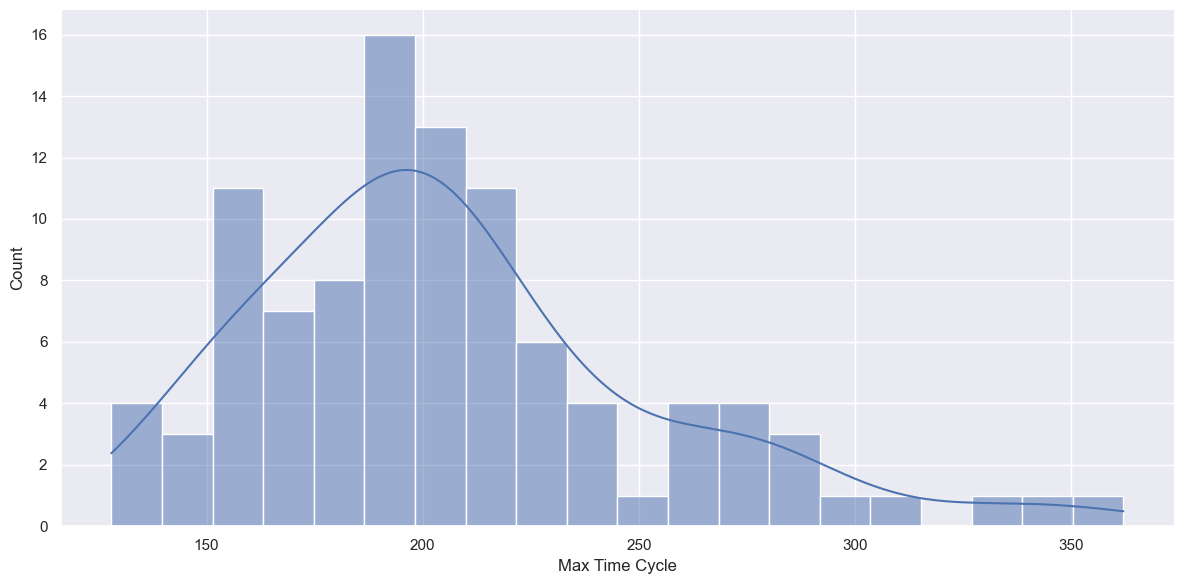

In [16]:
# Maximum Time Cycle

sns.displot(temp['cycle'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('Max Time Cycle')
plt.show()

## Adding RUL Column

In [17]:
max_cycle_per_engine = train.groupby(by='engine')['cycle'].max().to_frame(name='max_cycle') 
train = train.merge(max_cycle_per_engine, left_on='engine',right_index=True)
train["RUL"] = train["max_cycle"] - train['cycle']
train = train.drop("max_cycle", axis=1) 

In [18]:
corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

corr_masked = corr.mask(mask)

fig = px.imshow(corr_masked,
                color_continuous_scale="RdBu",
                title="Correlation Heatmap")

fig.update_layout(
    template="plotly_white",
    width=900,
    height=900,
)

fig.show()


In [19]:
corr_matrix = train.corr()

threshold = 0.5  

target_corr = corr_matrix['RUL']

high_pos = target_corr[target_corr >= threshold]
print("Highly Positive Correlated Features with y:")
print(high_pos)

high_neg = target_corr[target_corr <= -threshold]
print("\nHighly Negative Correlated Features with y:")
print(high_neg)


Highly Positive Correlated Features with y:
07 - (HPC outlet pressure) (psia)               0.657223
12 - (Ratio of fuel flow to Ps30) (pps/psia)    0.671983
20 - (High-pressure turbines Cool air flow)     0.629428
21 - (Low-pressure turbines Cool air flow)      0.635662
RUL                                             1.000000
Name: RUL, dtype: float64

Highly Negative Correlated Features with y:
cycle                                      -0.736241
02 - (LPC outlet temperature) (◦R)         -0.606484
03 - (HPC outlet temperature) (◦R)         -0.584520
04 - (LPT outlet temperature) (◦R)         -0.678948
08 - (Physical fan speed) (rpm)            -0.563968
11 - (HPC outlet Static pressure) (psia)   -0.696228
13 - (Corrected fan speed) (rpm)           -0.562569
15 - (Bypass Ratio)                        -0.642667
17 - (Bleed Enthalpy)                      -0.606154
Name: RUL, dtype: float64


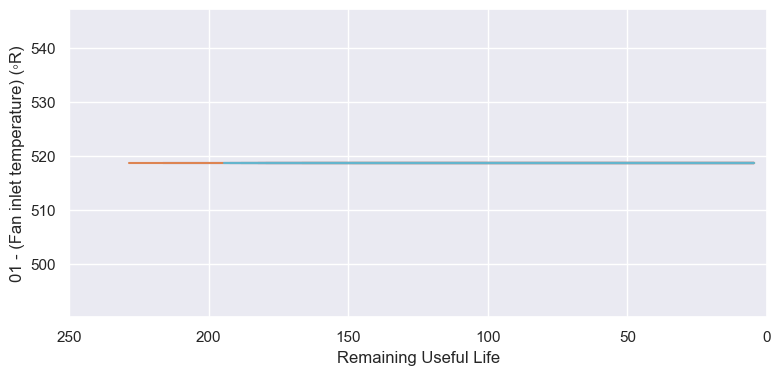

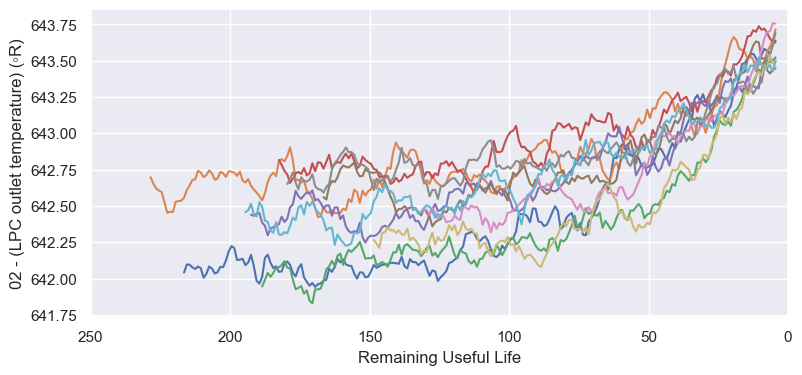

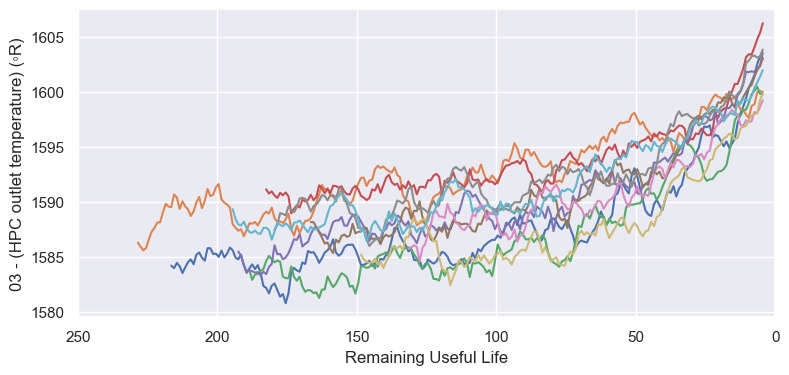

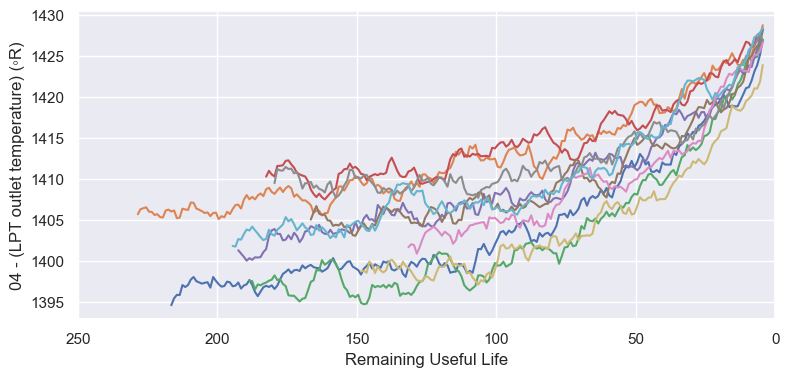

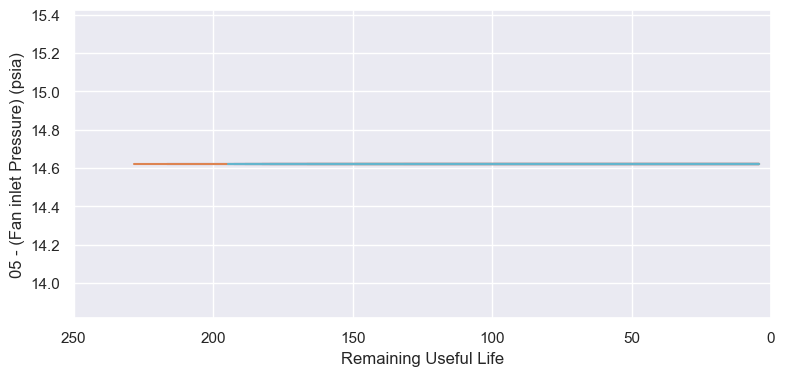

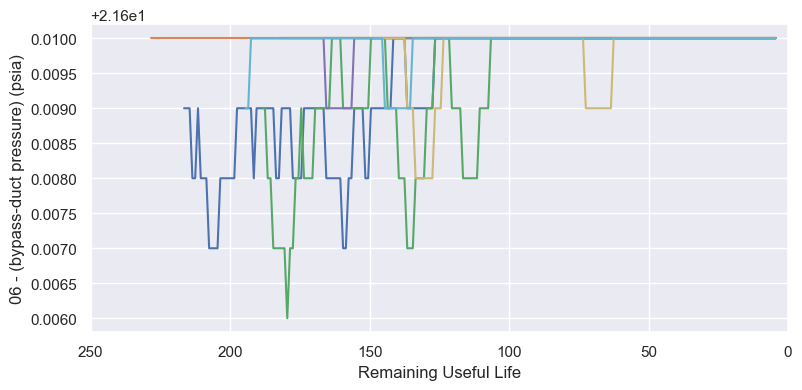

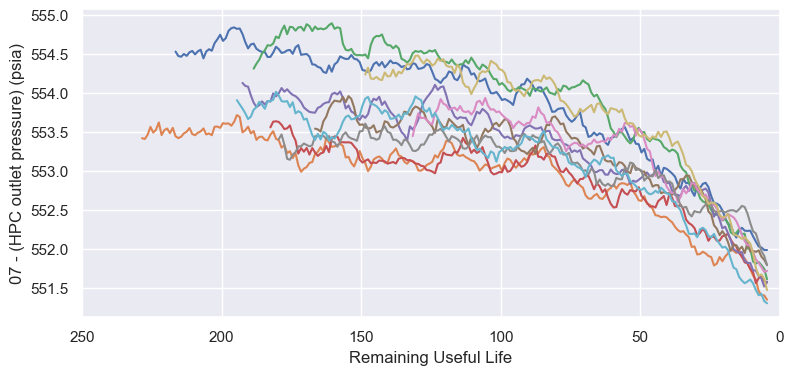

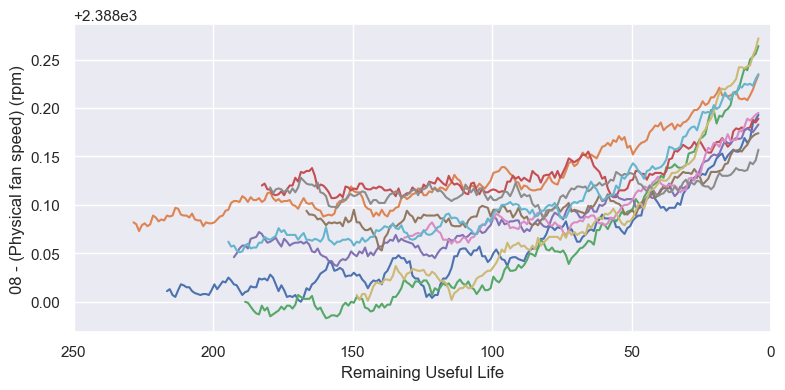

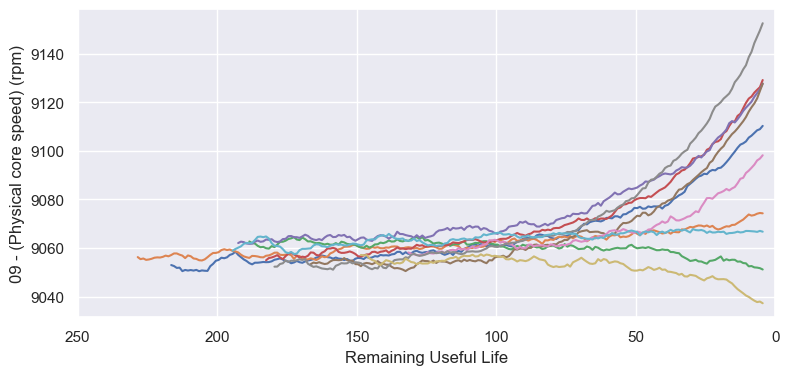

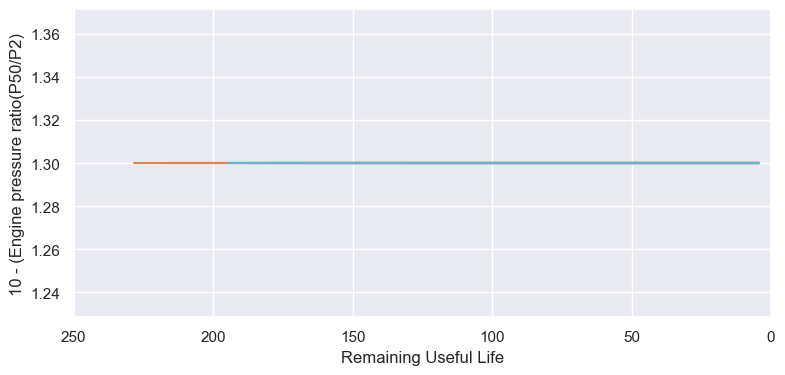

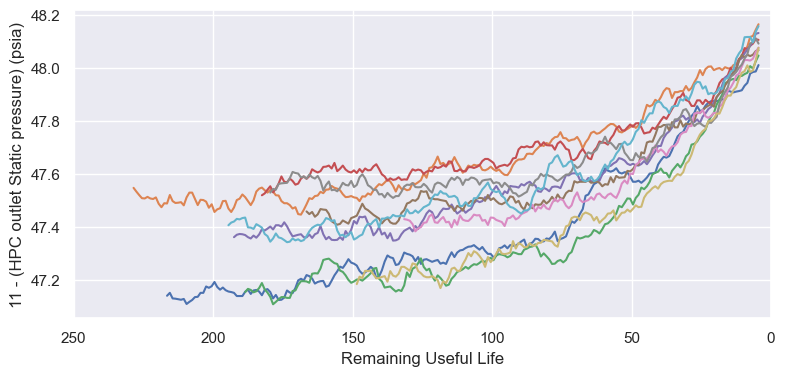

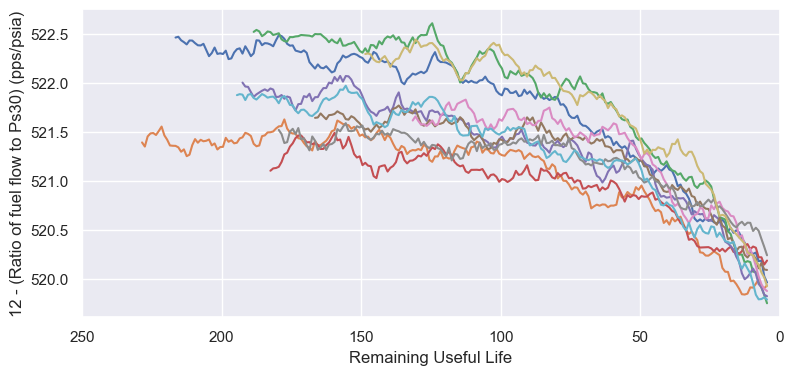

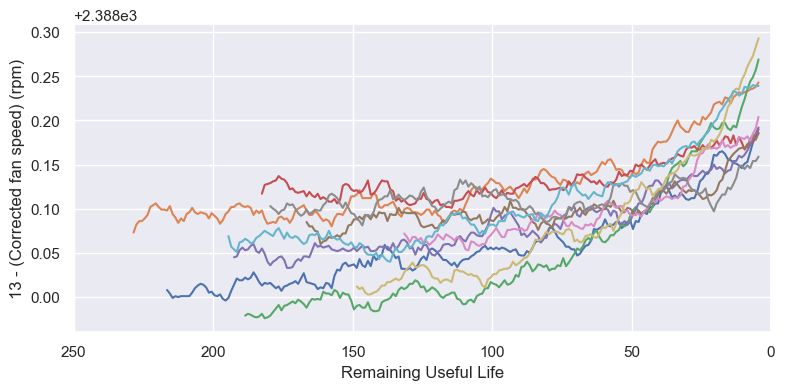

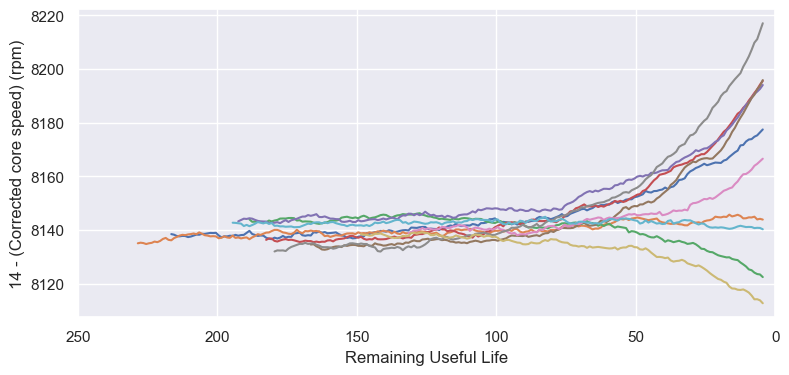

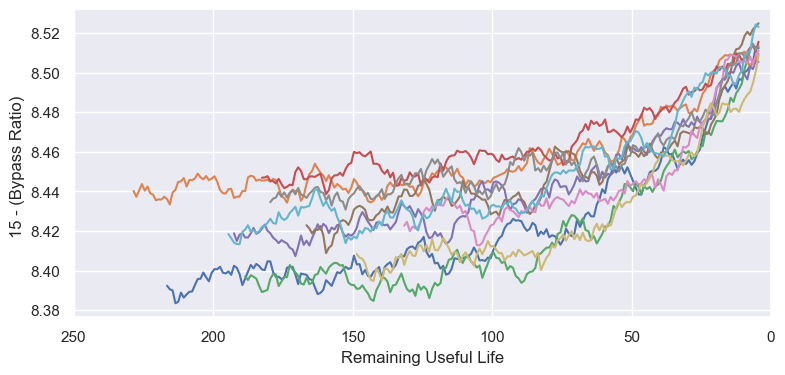

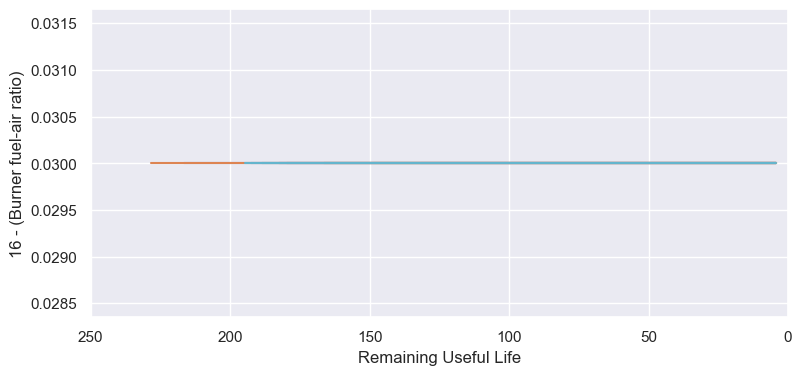

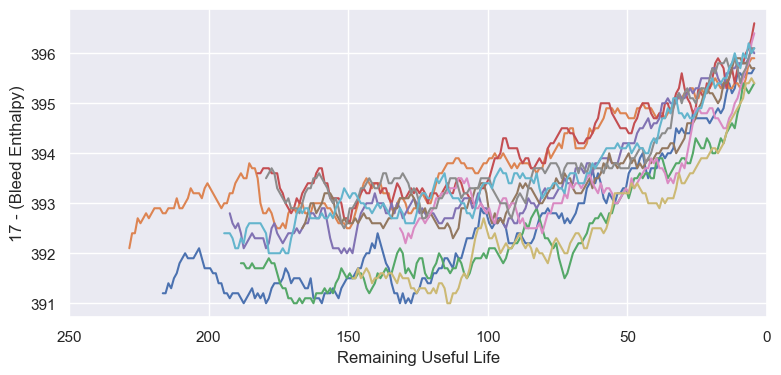

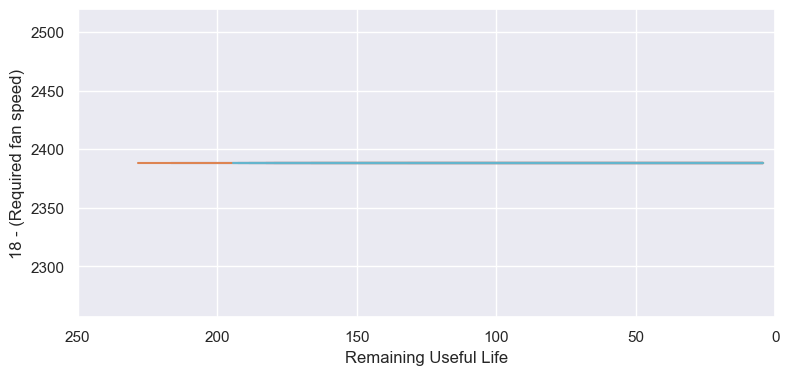

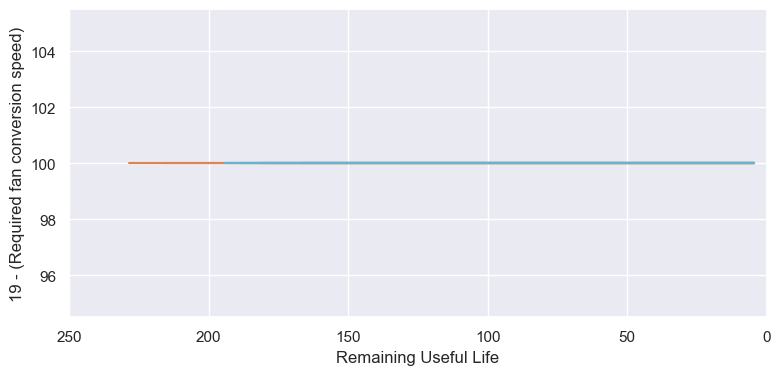

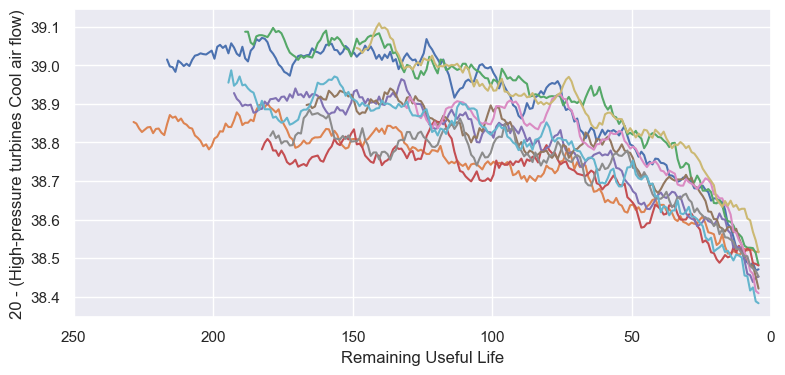

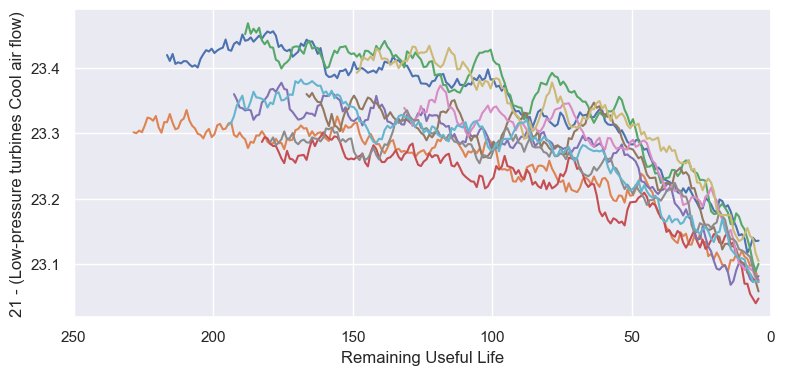

In [20]:
for col in train.columns[5:-1]:
    plt.figure(figsize=(9,4))
    signal_name = col

    for i in train['engine'].unique():
        if (i % 10 == 0): 
            plt.plot('RUL', signal_name, data=train[train['engine']==i].rolling(10).mean())
            plt.xlim(250, 0)
            plt.ylabel(signal_name)
            plt.xlabel('Remaining Useful Life')

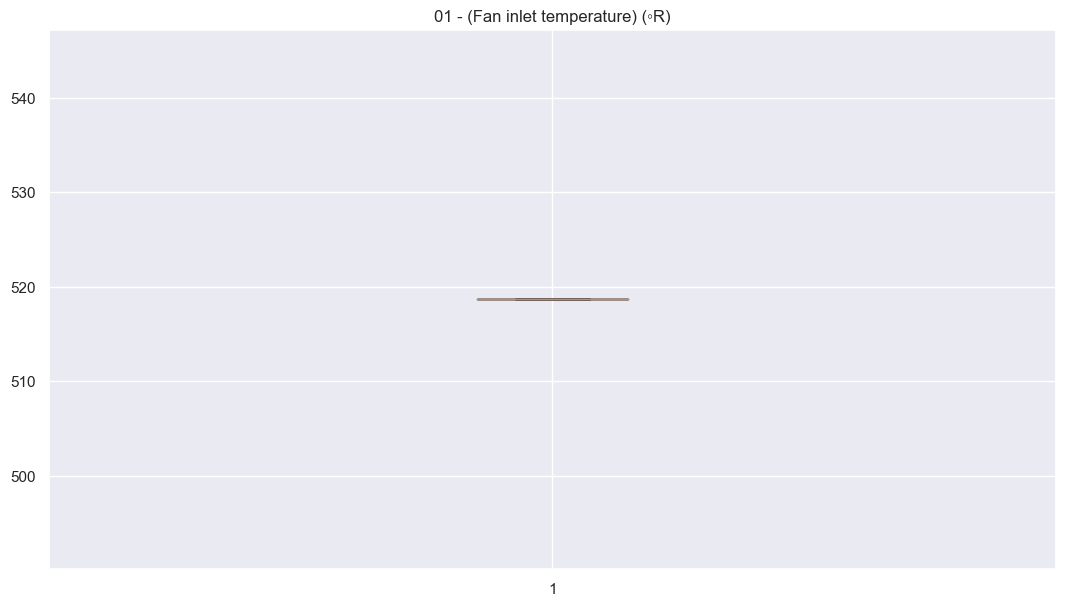

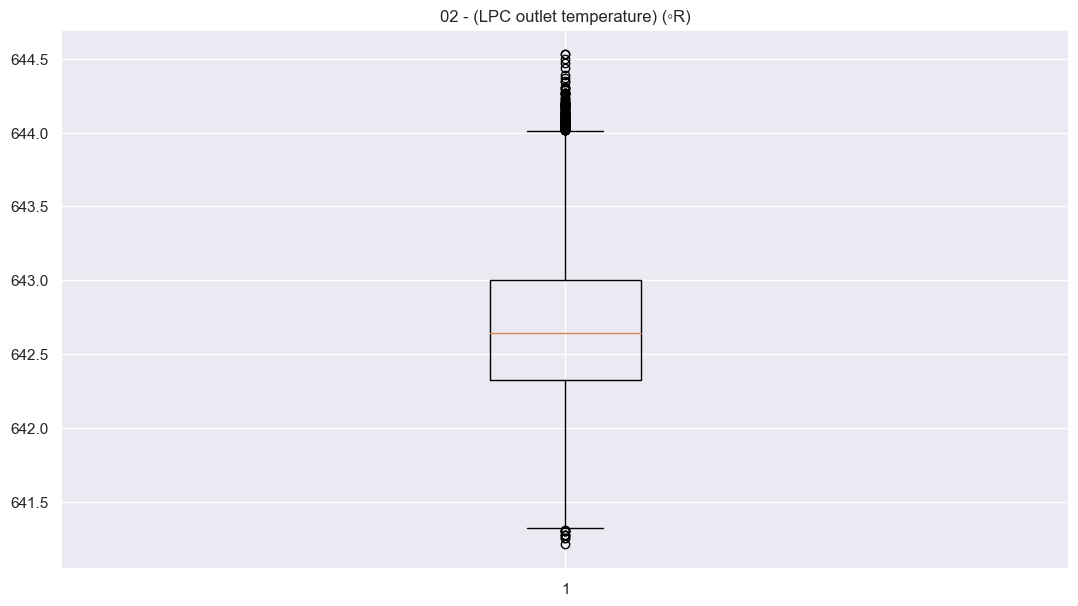

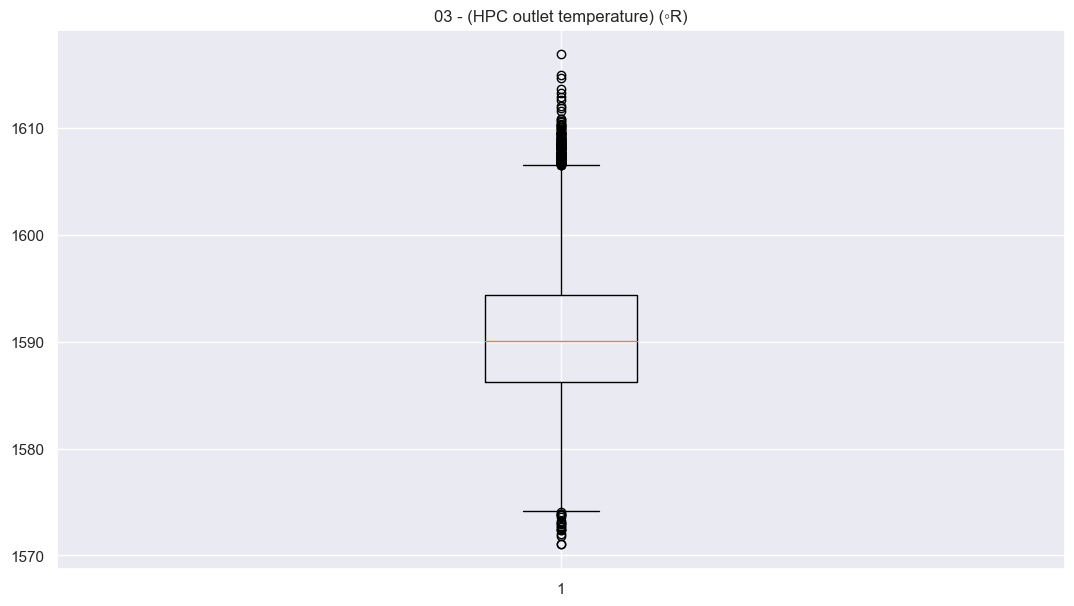

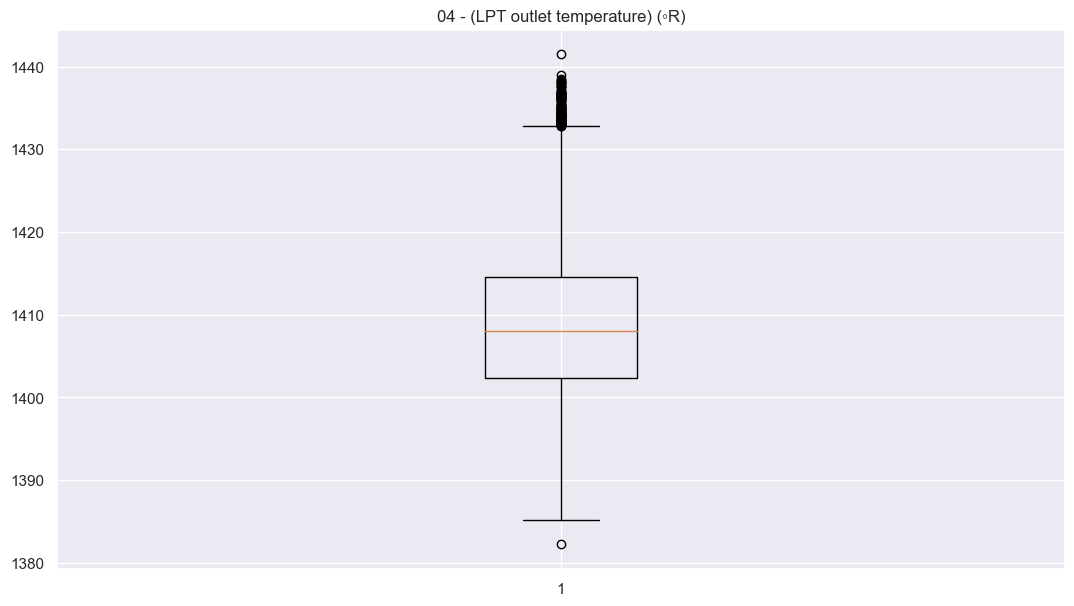

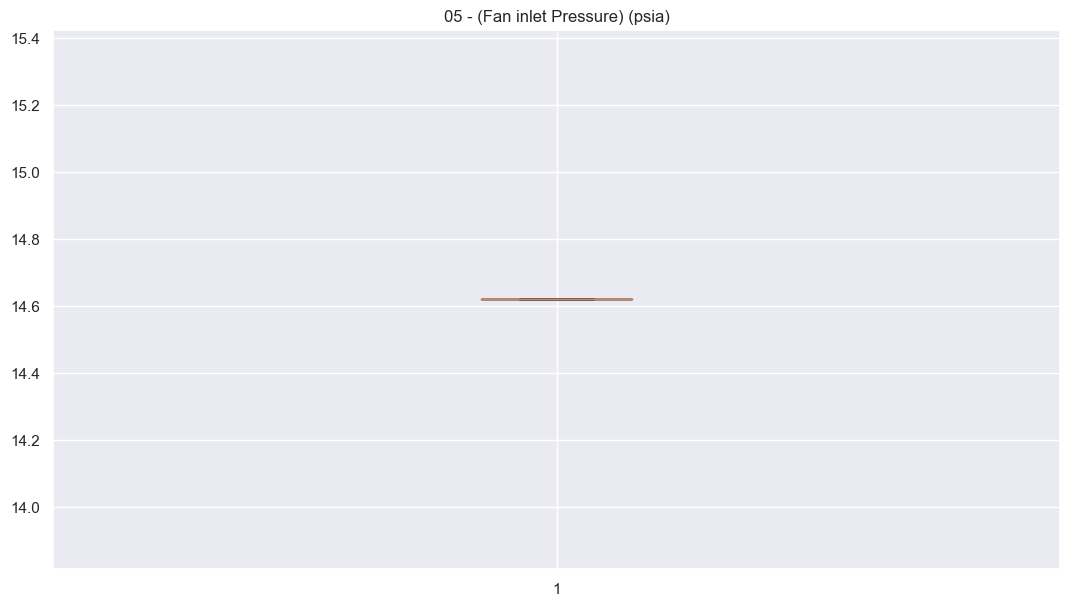

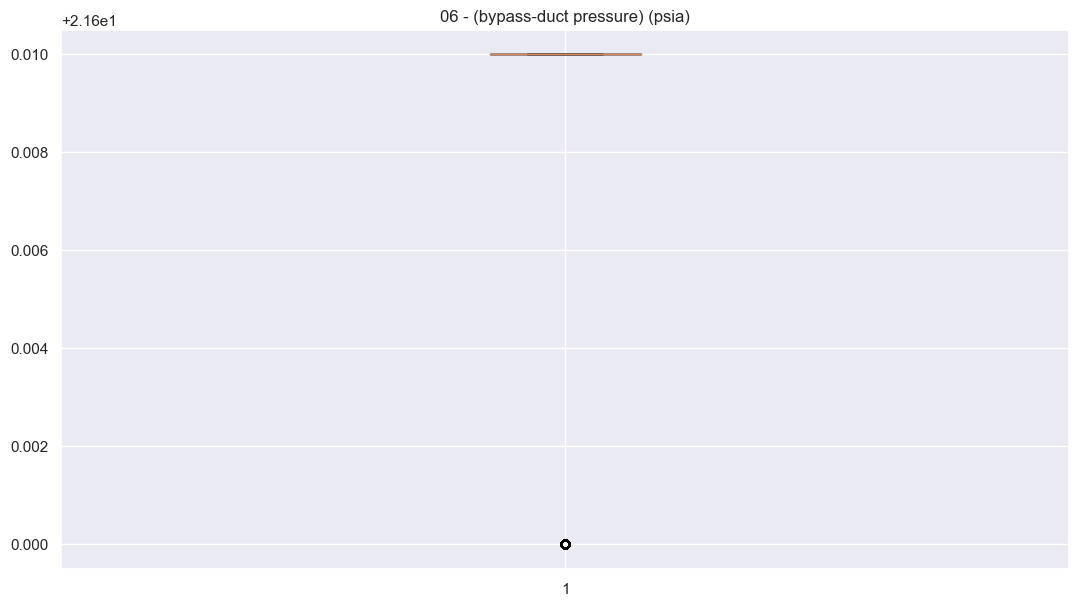

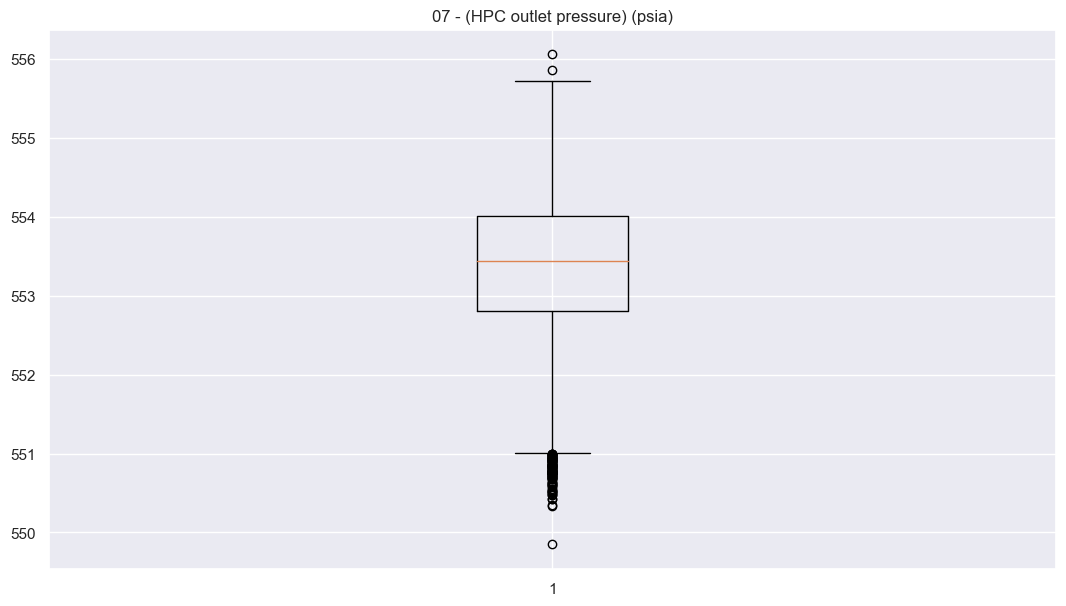

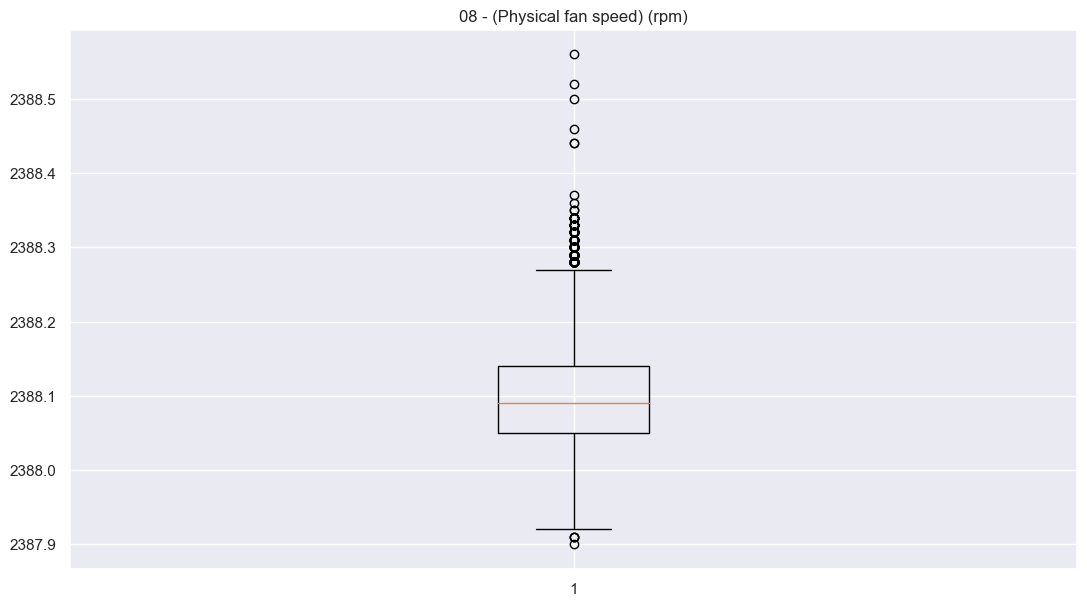

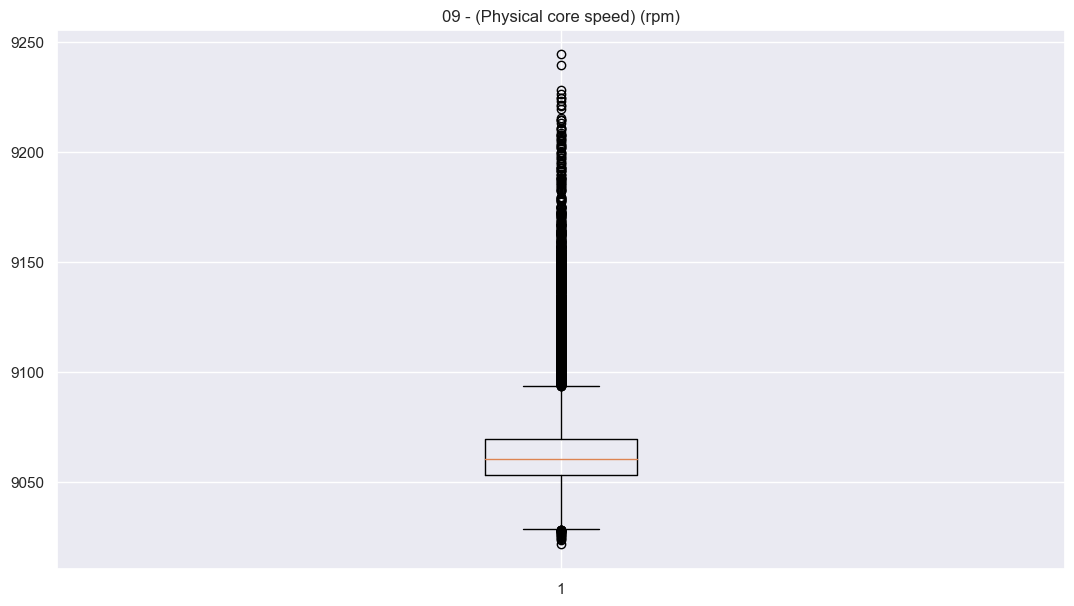

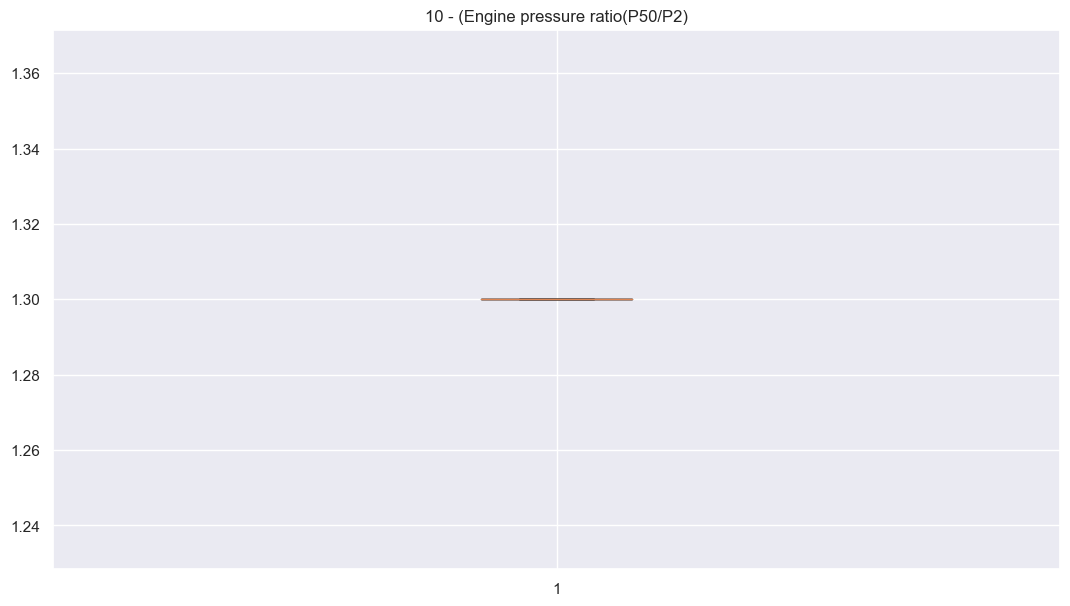

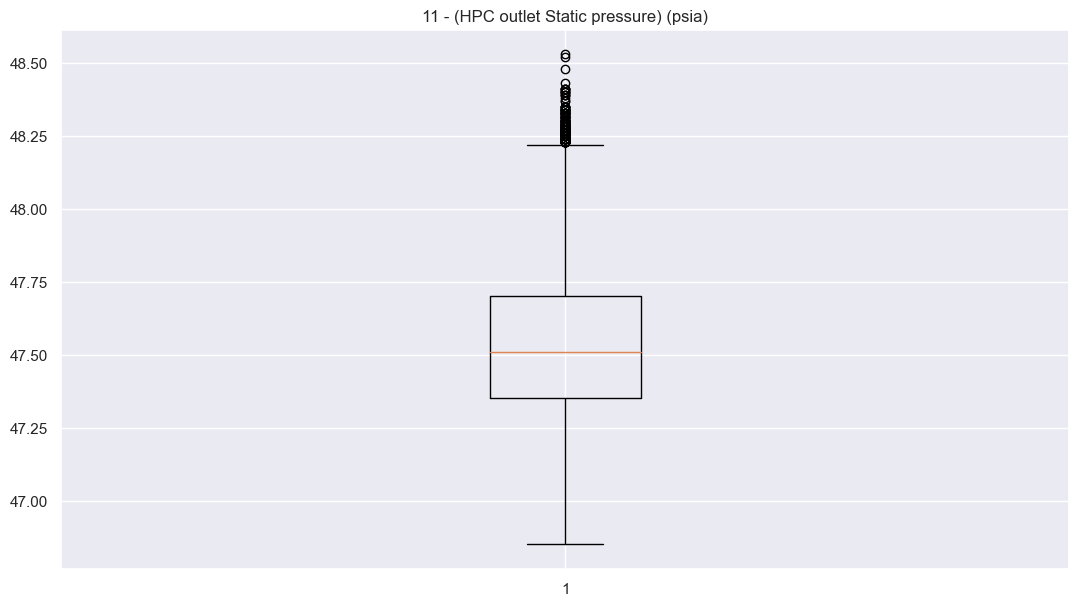

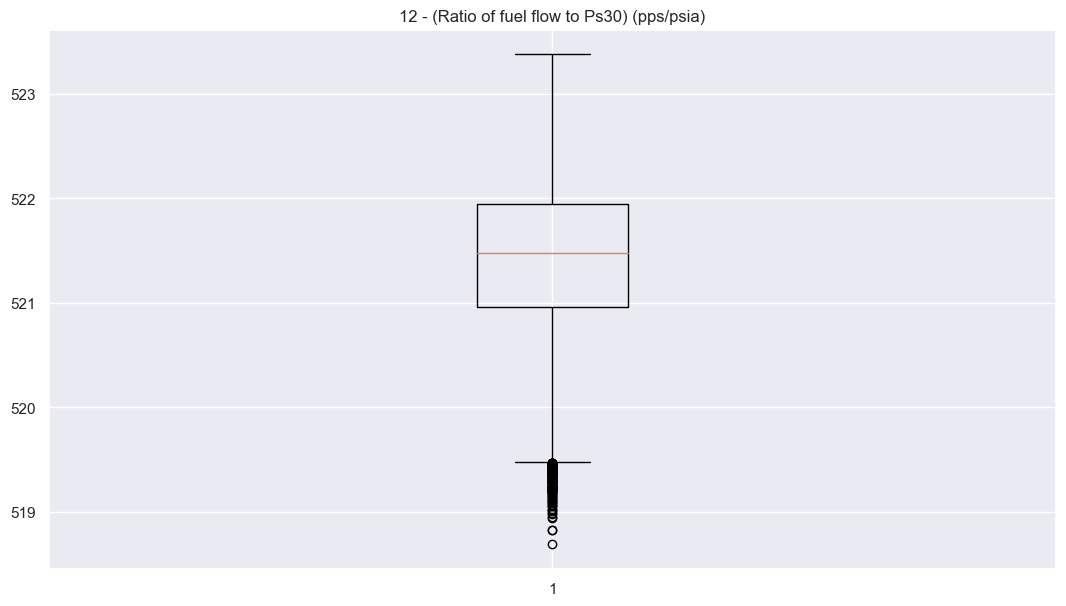

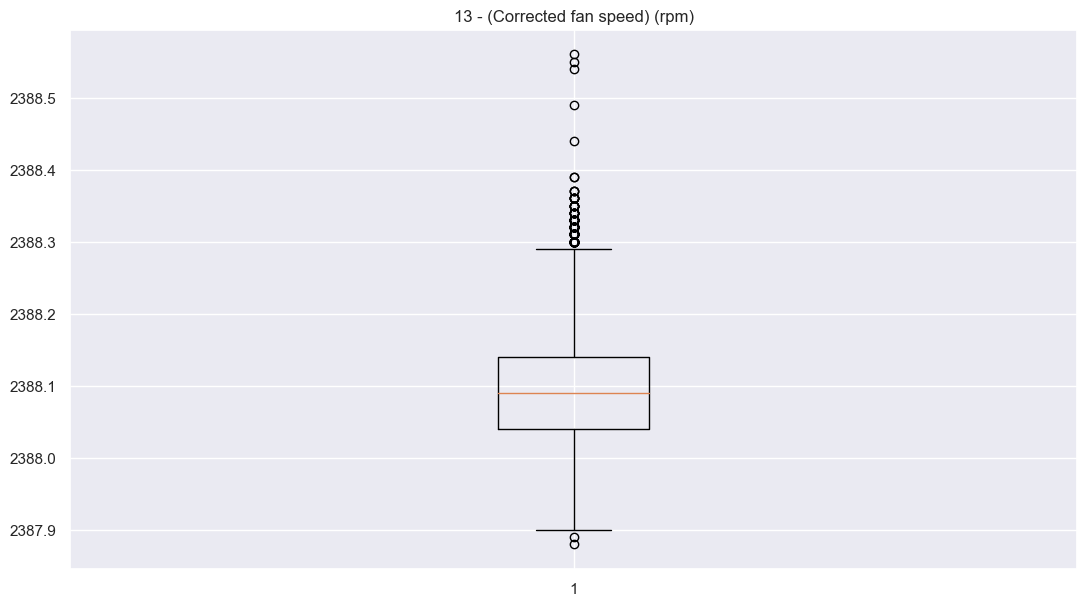

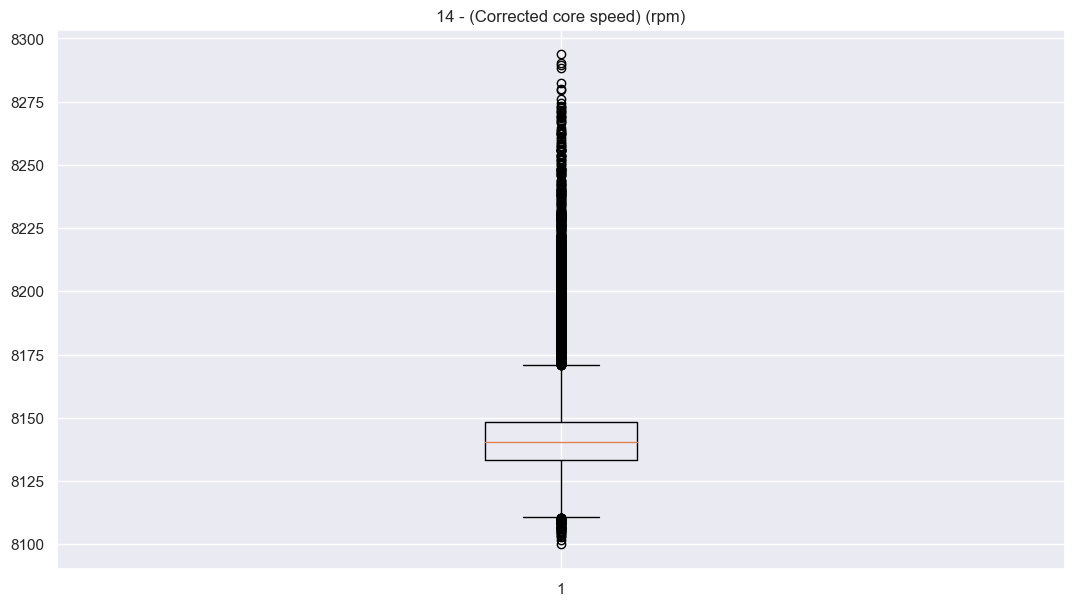

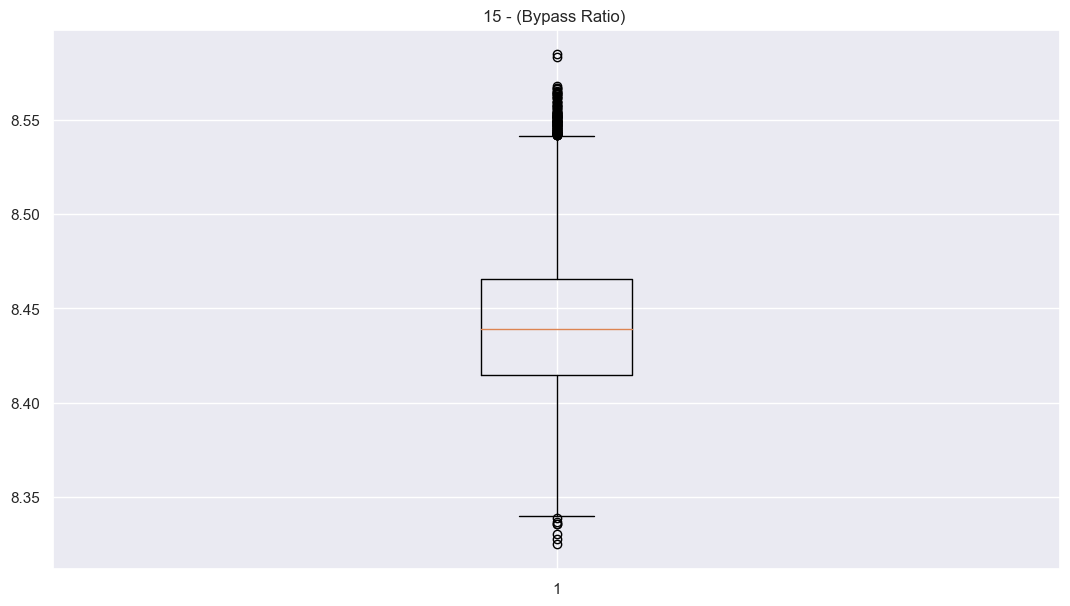

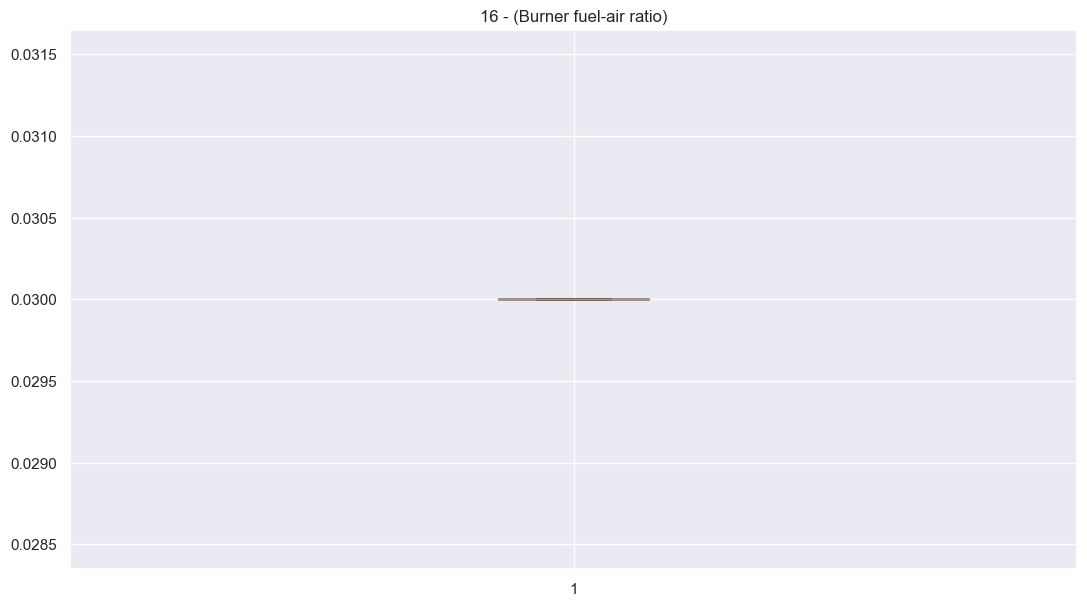

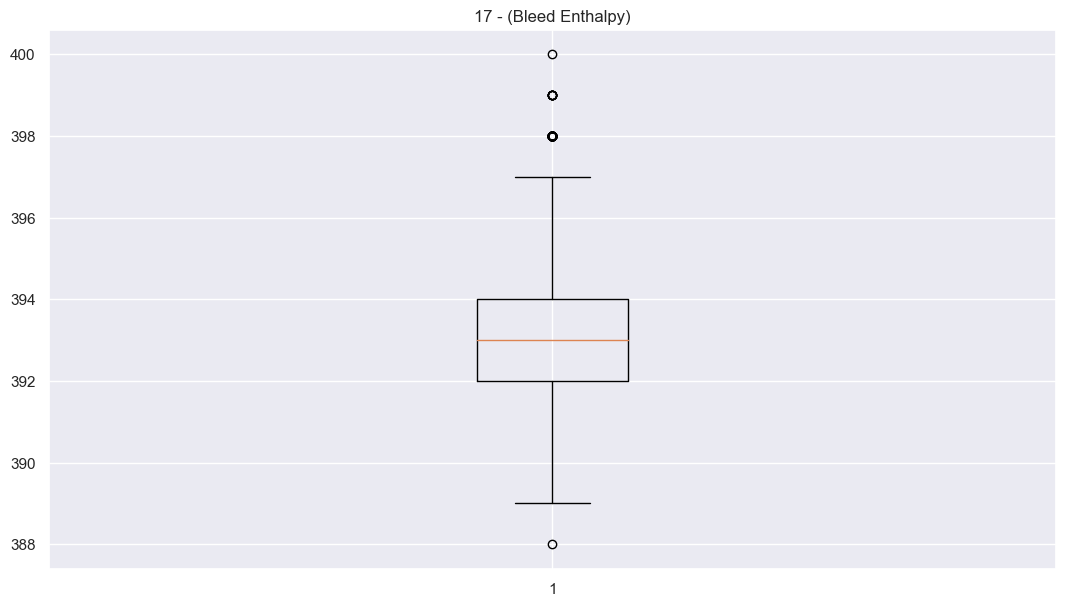

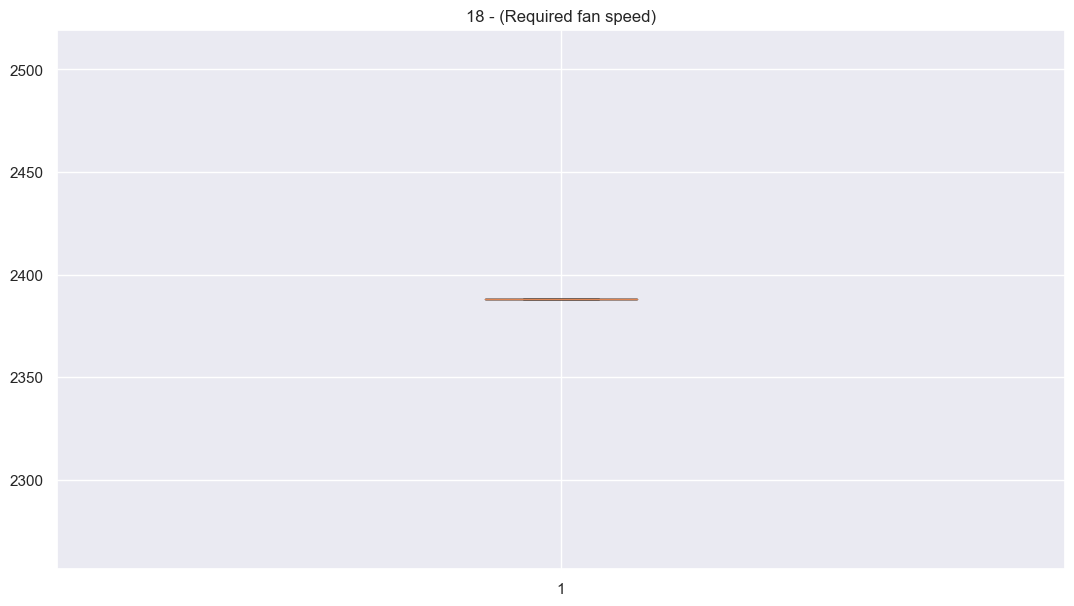

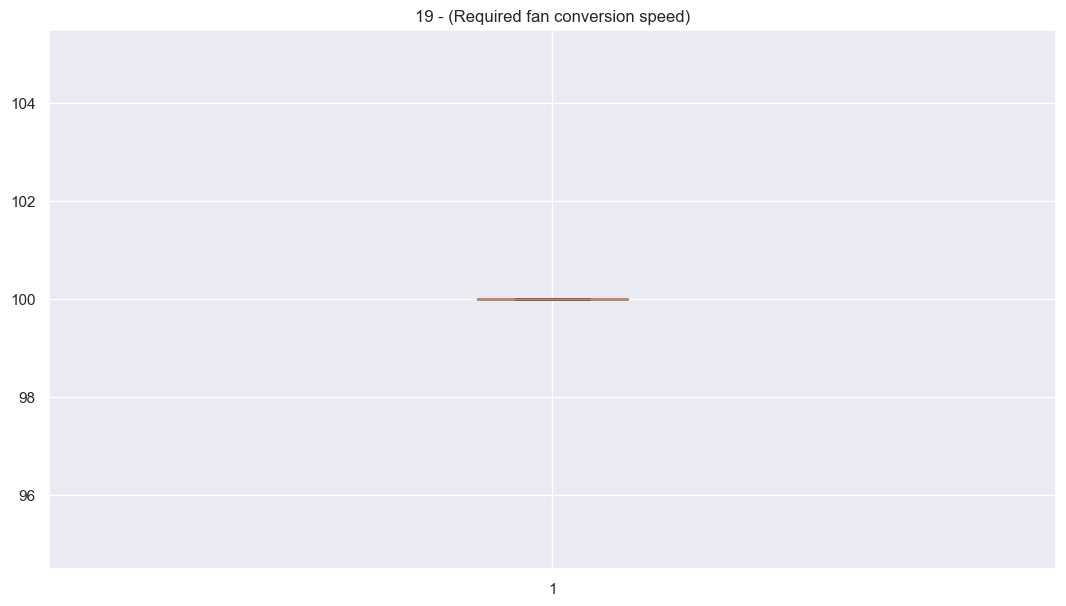

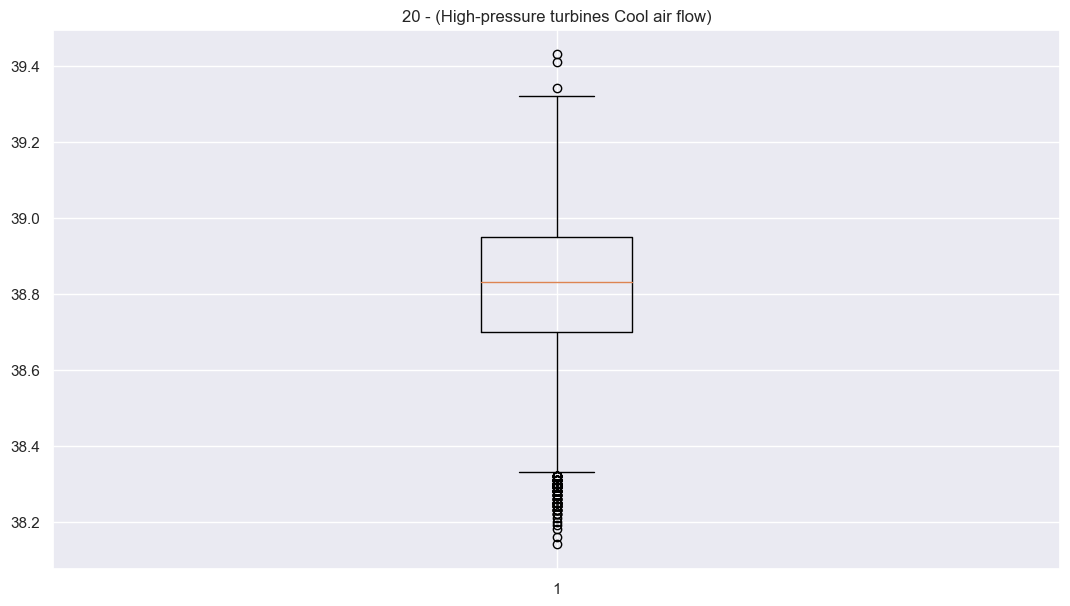

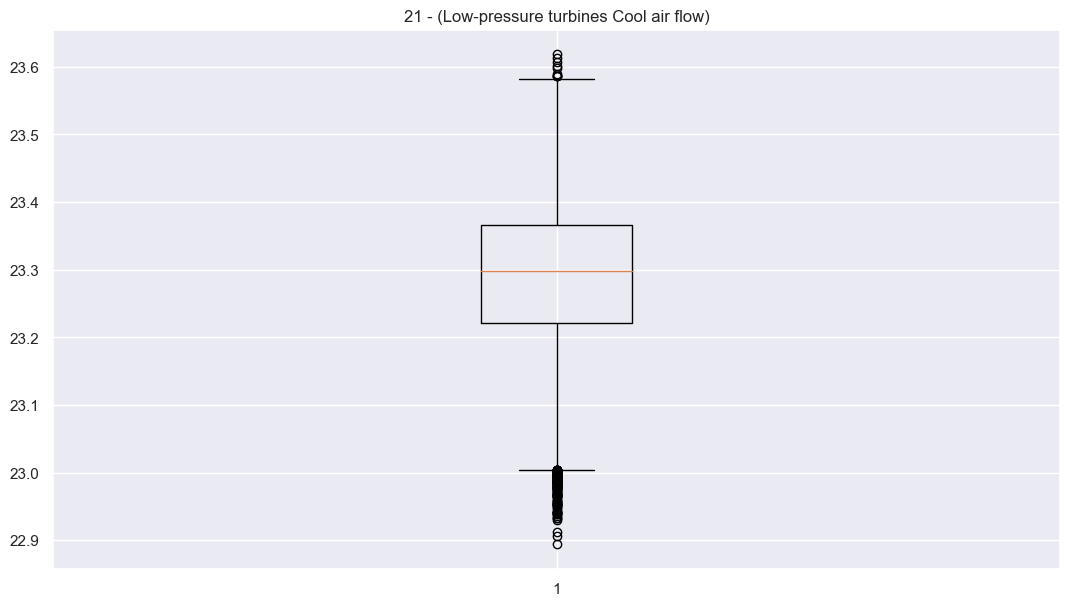

In [21]:
for x in train.columns[5:-1]:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

From the above plots, we calculate that Sensor 01,05,06,09,10,14,16,18,19 must be dropped.
Most of them are constant values and few of them are very low correlated.

In [22]:
train.columns

Index(['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3',
       '01 - (Fan inlet temperature) (◦R)',
       '02 - (LPC outlet temperature) (◦R)',
       '03 - (HPC outlet temperature) (◦R)',
       '04 - (LPT outlet temperature) (◦R)',
       '05 - (Fan inlet Pressure) (psia)',
       '06 - (bypass-duct pressure) (psia)',
       '07 - (HPC outlet pressure) (psia)', '08 - (Physical fan speed) (rpm)',
       '09 - (Physical core speed) (rpm)',
       '10 - (Engine pressure ratio(P50/P2)',
       '11 - (HPC outlet Static pressure) (psia)',
       '12 - (Ratio of fuel flow to Ps30) (pps/psia)',
       '13 - (Corrected fan speed) (rpm)', '14 - (Corrected core speed) (rpm)',
       '15 - (Bypass Ratio) ', '16 - (Burner fuel-air ratio)',
       '17 - (Bleed Enthalpy)', '18 - (Required fan speed)',
       '19 - (Required fan conversion speed)',
       '20 - (High-pressure turbines Cool air flow)',
       '21 - (Low-pressure turbines Cool air flow)', 'RUL'],
      dtype='object')

In [23]:
col_to_drop = [
    'engine','cycle',
    'setting_1', 'setting_2', 'setting_3',
    '01 - (Fan inlet temperature) (◦R)',
    '05 - (Fan inlet Pressure) (psia)',
    '06 - (bypass-duct pressure) (psia)',
    '09 - (Physical core speed) (rpm)',
    '10 - (Engine pressure ratio(P50/P2)',
    '14 - (Corrected core speed) (rpm)',
    '16 - (Burner fuel-air ratio)',
    '18 - (Required fan speed)',
    '19 - (Required fan conversion speed)',
]
train.drop(columns=col_to_drop,inplace=True)
train.shape

(20631, 13)

In [24]:
valid = valid.groupby('engine').last().reset_index()
valid.drop(columns=col_to_drop,inplace=True)
valid.shape

(100, 12)

In [25]:
train.head()

02 - (LPC outlet temperature) (◦R)  03 - (HPC outlet temperature) (◦R)  \
0                              641.82                             1589.70   
1                              642.15                             1591.82   
2                              642.35                             1587.99   
3                              642.35                             1582.79   
4                              642.37                             1582.85   

   04 - (LPT outlet temperature) (◦R)  07 - (HPC outlet pressure) (psia)  \
0                             1400.60                             554.36   
1                             1403.14                             553.75   
2                             1404.20                             554.26   
3                             1401.87                             554.45   
4                             1406.22                             554.00   

   08 - (Physical fan speed) (rpm)  11 - (HPC outlet Static pressure) (psia)  \
0                          2388.06                                     47.47   
1                          2388.04                                     47.49   
2                          2388.08                                     47.27   
3                          2388.11                                     47.13   
4                          2388.06                                     47.28   

   12 - (Ratio of fuel flow to Ps30) (pps/psia)  \
0                                        521.66   
1                                        522.28   
2                                        522.42   
3                                        522.86   
4                                        522.19   

   13 - (Corrected fan speed) (rpm)  15 - (Bypass Ratio)   \
0                           2388.02                8.4195   
1                           2388.07                8.4318   
2                           2388.03                8.4178   
3                           2388.08                8.3682   
4                           2388.04                8.4294   

   17 - (Bleed Enthalpy)  20 - (High-pressure turbines Cool air flow)  \
0                    392                                        39.06   
1                    392                                        39.00   
2                    390                                        38.95   
3                    392                                        38.88   
4                    393                                        38.90   

   21 - (Low-pressure turbines Cool air flow)  RUL  
0                                     23.4190  191  
1                                     23.4236  190  
2                                     23.3442  189  
3                                     23.3739  188  
4                                     23.4044  187

In [26]:
valid.head()

02 - (LPC outlet temperature) (◦R)  03 - (HPC outlet temperature) (◦R)  \
0                              642.58                             1581.22   
1                              642.55                             1586.59   
2                              642.88                             1589.75   
3                              642.78                             1594.53   
4                              642.27                             1589.94   

   04 - (LPT outlet temperature) (◦R)  07 - (HPC outlet pressure) (psia)  \
0                             1398.91                             554.42   
1                             1410.83                             553.52   
2                             1418.89                             552.59   
3                             1406.88                             552.64   
4                             1419.36                             553.29   

   08 - (Physical fan speed) (rpm)  11 - (HPC outlet Static pressure) (psia)  \
0                          2388.08                                     47.23   
1                          2388.10                                     47.67   
2                          2388.16                                     47.88   
3                          2388.13                                     47.65   
4                          2388.10                                     47.46   

   12 - (Ratio of fuel flow to Ps30) (pps/psia)  \
0                                        521.79   
1                                        521.74   
2                                        520.83   
3                                        521.88   
4                                        521.00   

   13 - (Corrected fan speed) (rpm)  15 - (Bypass Ratio)   \
0                           2388.06                8.4024   
1                           2388.09                8.4505   
2                           2388.14                8.4119   
3                           2388.11                8.4634   
4                           2388.15                8.4362   

   17 - (Bleed Enthalpy)  20 - (High-pressure turbines Cool air flow)  \
0                    393                                        38.81   
1                    391                                        38.81   
2                    395                                        38.93   
3                    395                                        38.58   
4                    394                                        38.75   

   21 - (Low-pressure turbines Cool air flow)  
0                                     23.3552  
1                                     23.2618  
2                                     23.2740  
3                                     23.2581  
4                                     23.4117

## Model Implementation

In [28]:
eval_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R²'])

In [29]:
def evaluate_regression(y_true, y_pred, model_name, scale=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print("---------------------------")
    
    # Add to eval_df
    eval_df.loc[model_name + scale] = [round(mae, 4), round(mse, 4), round(rmse, 4), round(r2, 4)]


In [30]:
def plot_predActual(y_test, y_test_hat,model):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.title(f'{model} Validation Plot', fontsize=75)
    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### Train Test Split

In [31]:
X = train.drop(columns=['RUL'])
y = train['RUL']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [32]:
X_train.shape

(16504, 12)

In [33]:
X_test.shape

(4127, 12)

## Without Standardization

In [34]:
def model(model,name):
    model.fit(X_train,y_train)

    y_pred = model.predict(X_train)
    evaluate_regression(y_train, y_pred, f'{name} Train')

    y_pred = model.predict(X_test)
    evaluate_regression(y_test, y_pred, f'{name} Test')

    y_pred = model.predict(valid)
    evaluate_regression(rul_df, y_pred, f'{name} Valid')

    plot_predActual(rul_df, y_pred, name)

In [35]:
# Linear Regression
lr = LinearRegression(fit_intercept=True)

# Support Vector Regressor
svr = SVR(kernel='rbf', C=100, epsilon=0.1)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, max_depth=None)

# XGBoost Regressor
xg = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)

--- Linear Regression Train Evaluation ---
MAE  : 34.8973
MSE  : 2107.1581
RMSE : 45.9038
R²   : 0.5588
---------------------------
--- Linear Regression Test Evaluation ---
MAE  : 34.1018
MSE  : 1975.3518
RMSE : 44.4449
R²   : 0.5721
---------------------------
--- Linear Regression Valid Evaluation ---
MAE  : 26.1888
MSE  : 1112.4743
RMSE : 33.3538
R²   : 0.3558
---------------------------


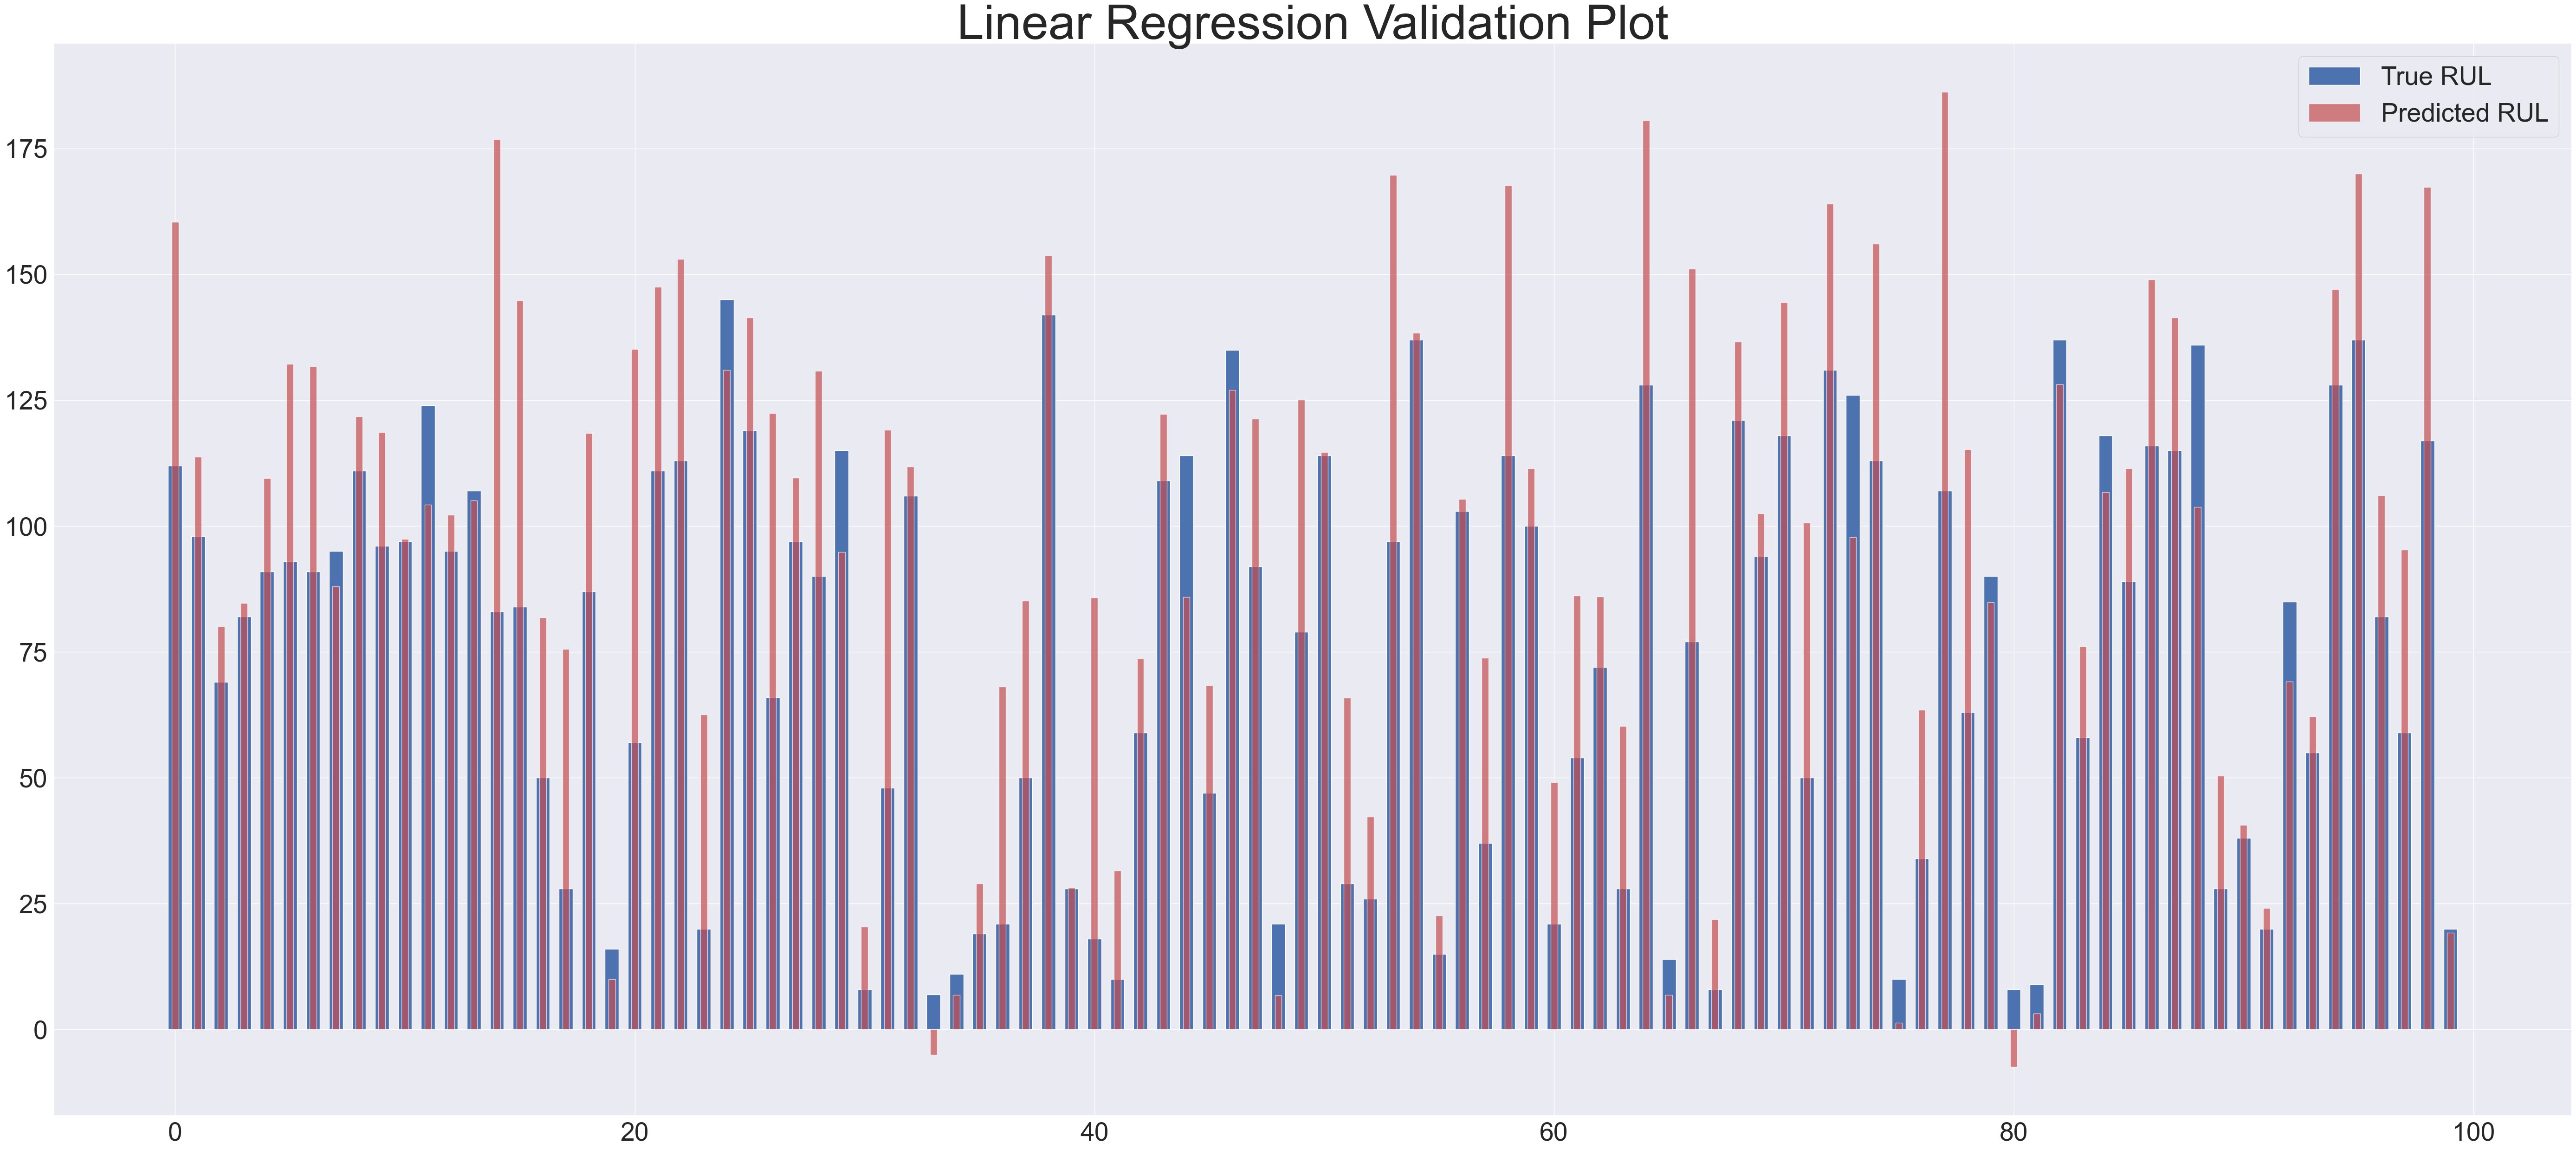

In [36]:
model(lr,'Linear Regression')

--- Random Forest Train Evaluation ---
MAE  : 12.4481
MSE  : 288.1353
RMSE : 16.9745
R²   : 0.9397
---------------------------
--- Random Forest Test Evaluation ---
MAE  : 32.8880
MSE  : 1946.5350
RMSE : 44.1196
R²   : 0.5783
---------------------------
--- Random Forest Valid Evaluation ---
MAE  : 25.5358
MSE  : 1223.4819
RMSE : 34.9783
R²   : 0.2915
---------------------------


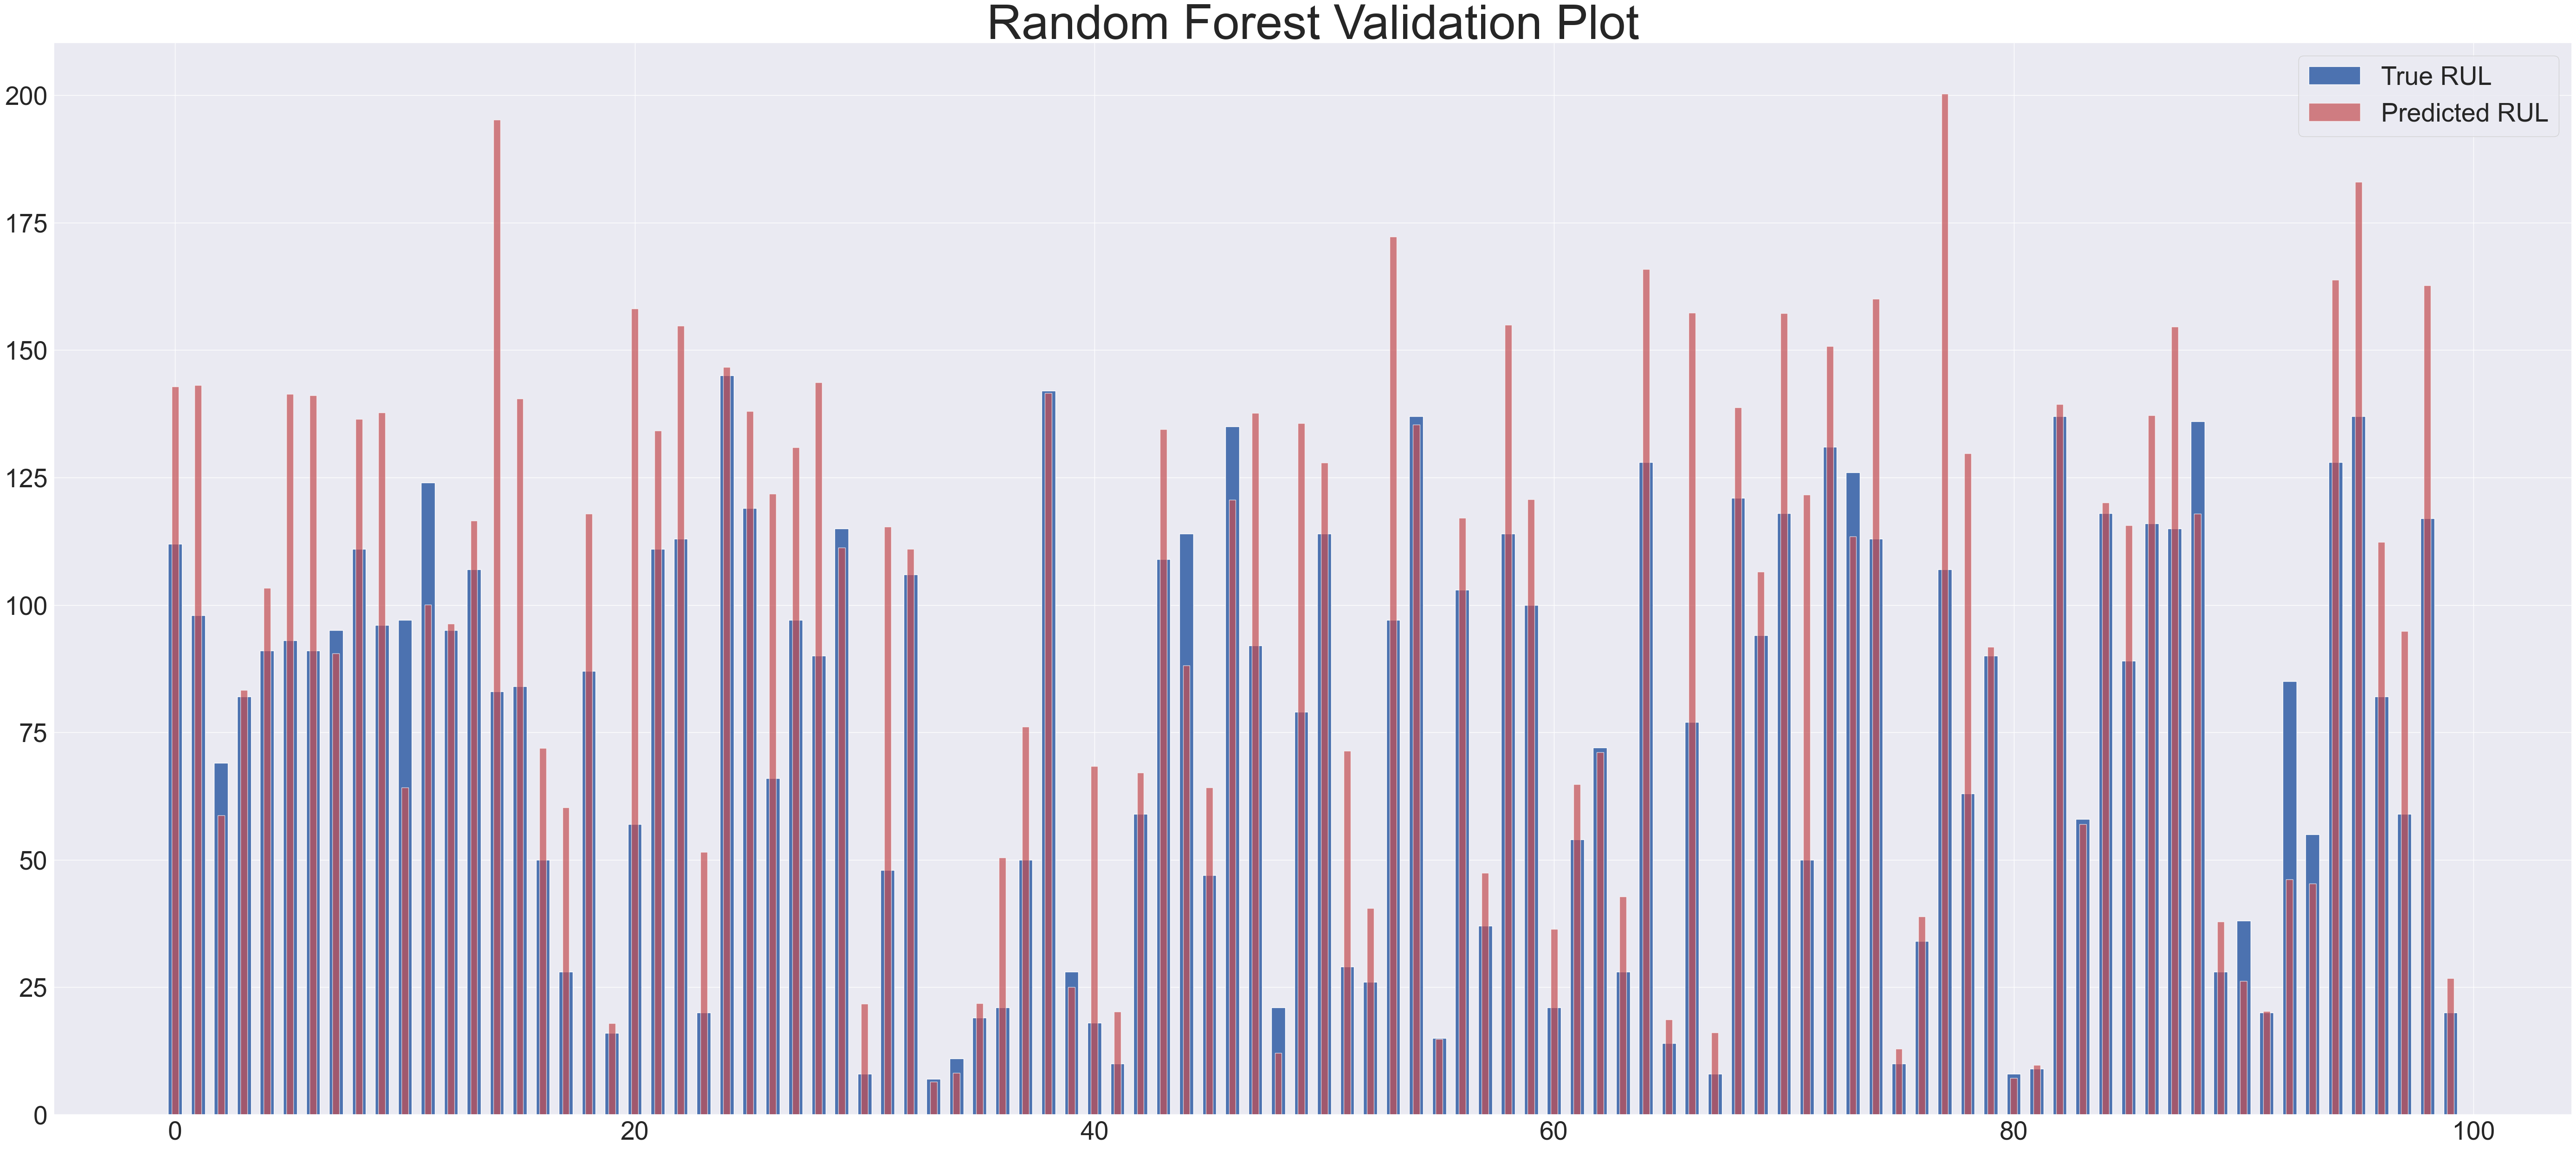

In [37]:
model(rf,'Random Forest')

--- SVR Train Evaluation ---
MAE  : 45.5987
MSE  : 3358.1274
RMSE : 57.9494
R²   : 0.2969
---------------------------
--- SVR Test Evaluation ---
MAE  : 45.0019
MSE  : 3216.7219
RMSE : 56.7162
R²   : 0.3031
---------------------------
--- SVR Valid Evaluation ---
MAE  : 27.7691
MSE  : 1093.1235
RMSE : 33.0624
R²   : 0.3670
---------------------------


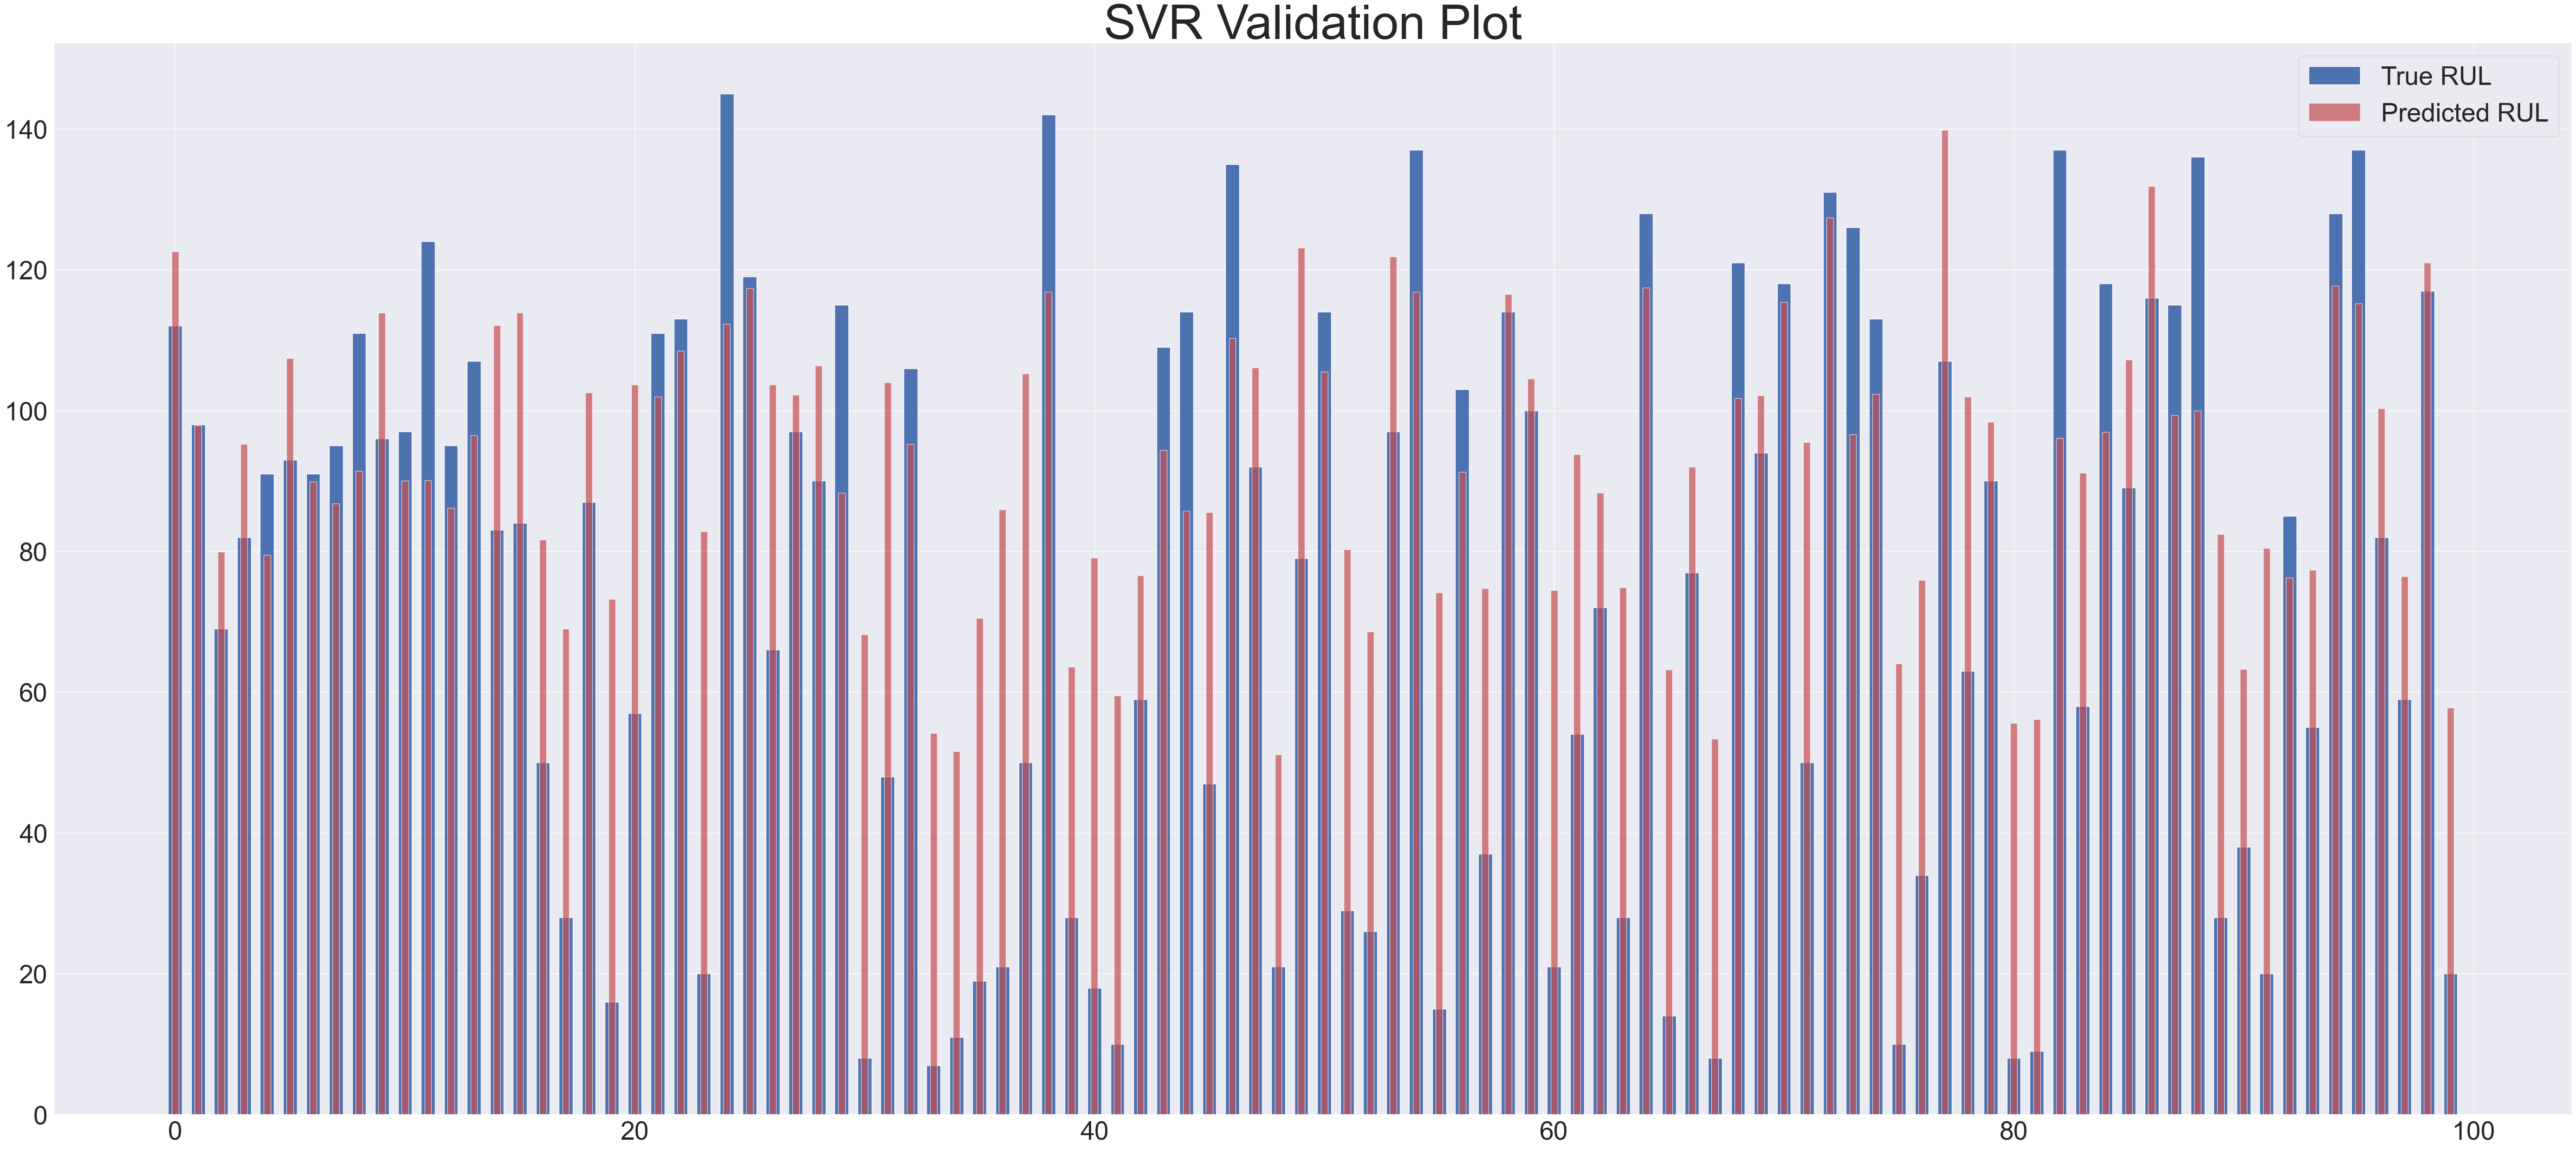

In [38]:
model(svr,'SVR')

--- XGBoost Train Evaluation ---
MAE  : 28.8464
MSE  : 1566.2283
RMSE : 39.5756
R²   : 0.6721
---------------------------
--- XGBoost Test Evaluation ---
MAE  : 32.4365
MSE  : 1923.0140
RMSE : 43.8522
R²   : 0.5834
---------------------------
--- XGBoost Valid Evaluation ---
MAE  : 24.5035
MSE  : 1114.5713
RMSE : 33.3852
R²   : 0.3546
---------------------------


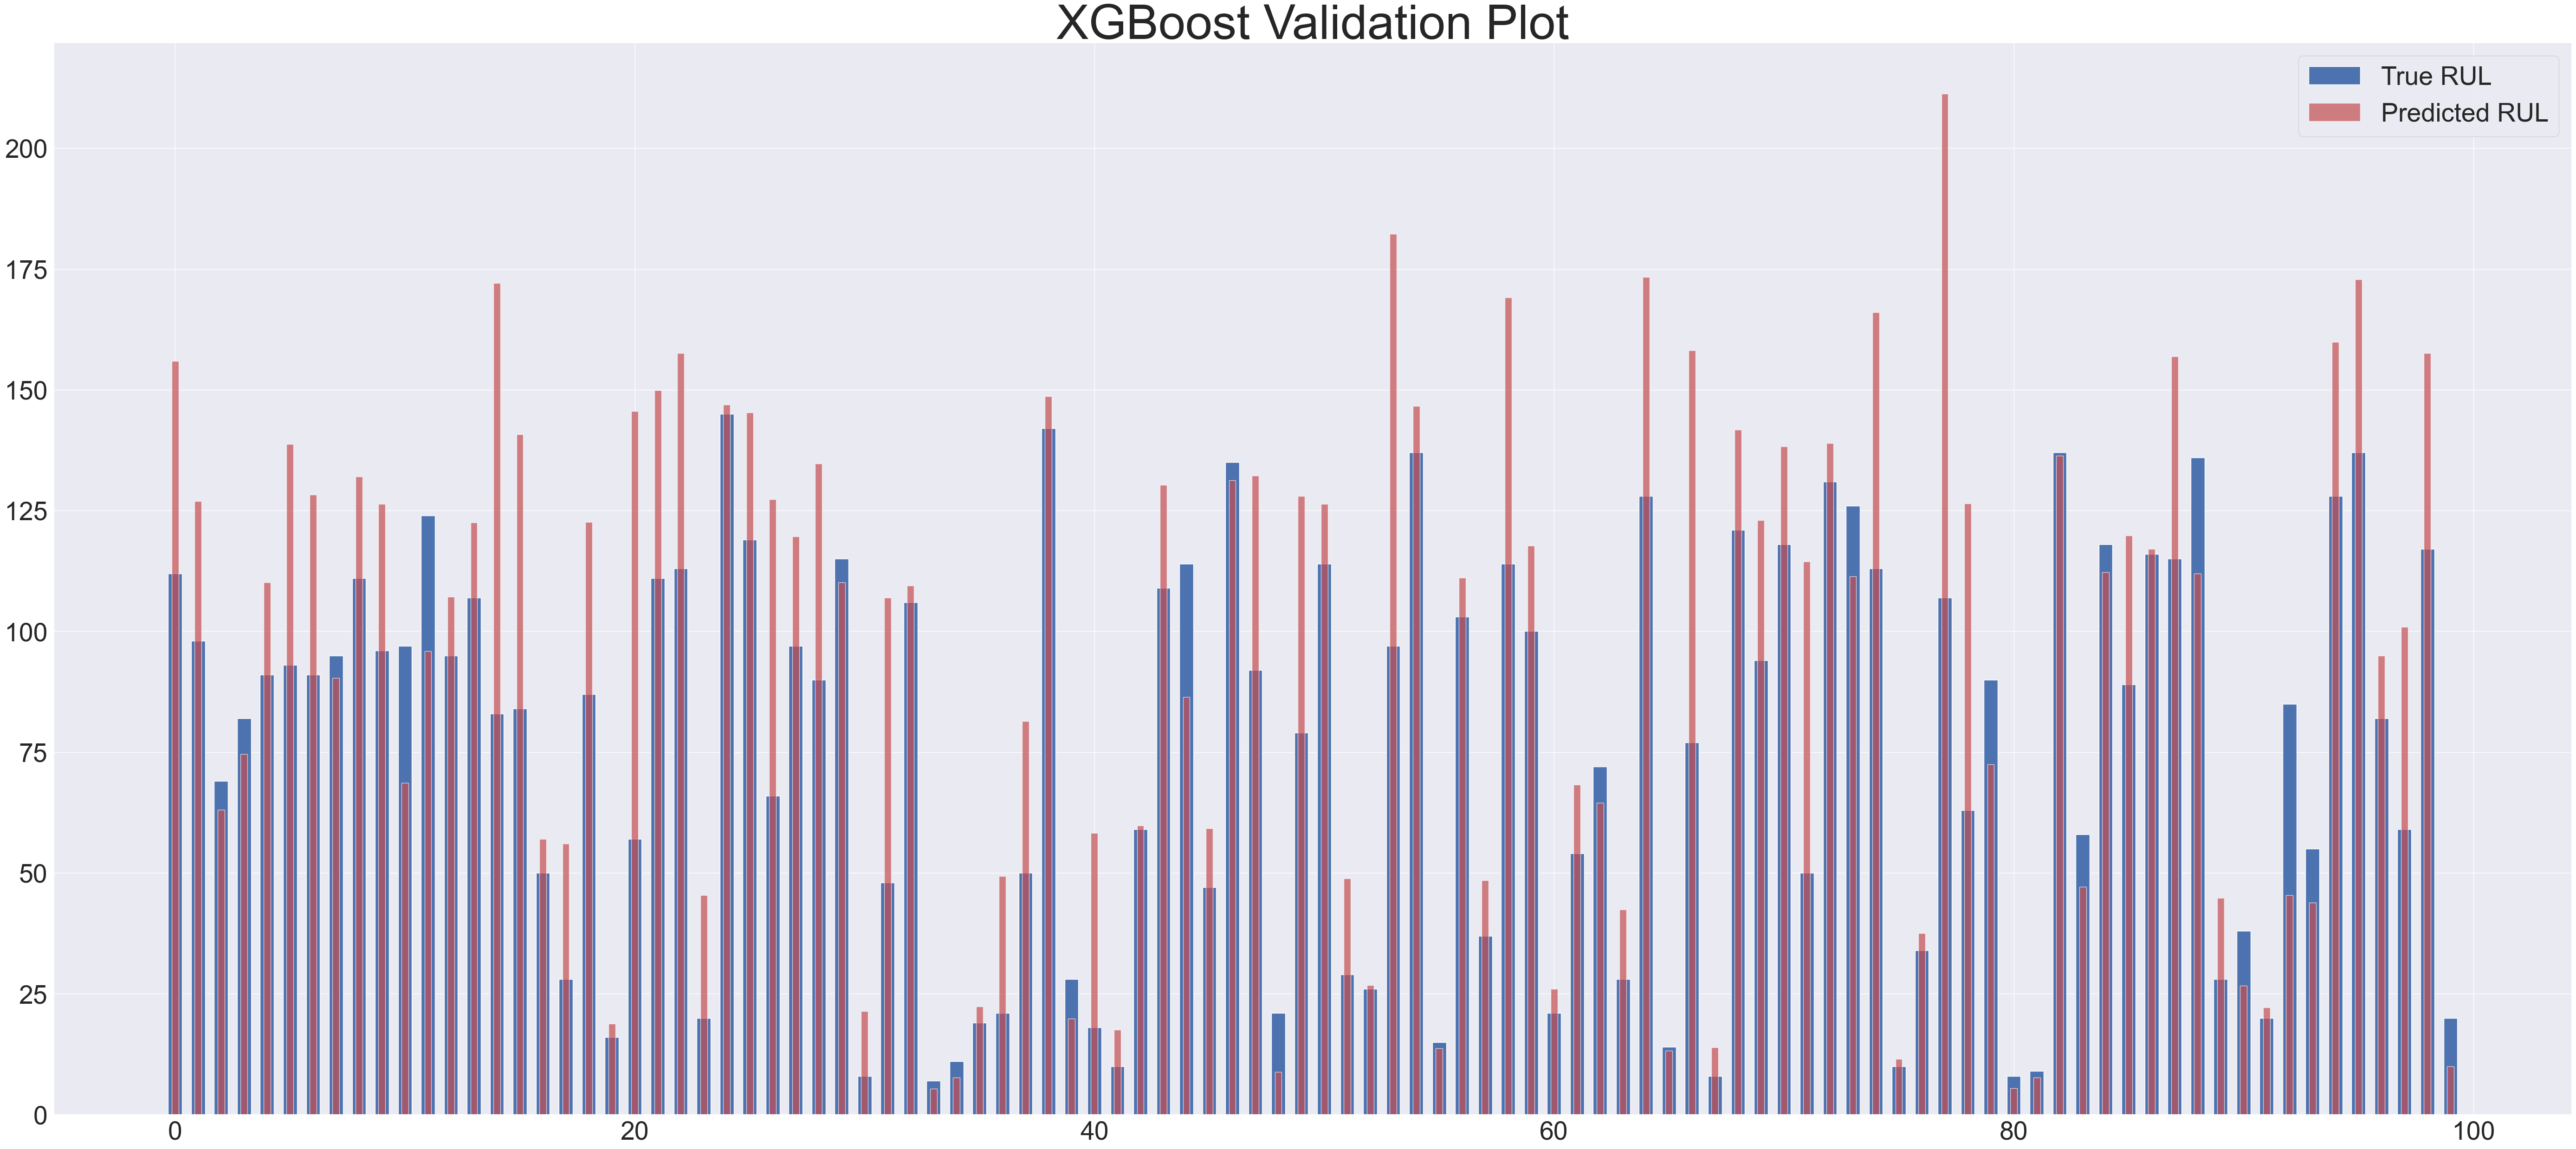

In [39]:
model(xg,'XGBoost')

### With Standardization

In [40]:
def model_standardization(model,name):
    
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_valid_scaled = scaler.transform(valid)
    
    model.fit(X_train_scaled,y_train)

    y_pred = model.predict(X_train_scaled)
    evaluate_regression(y_train, y_pred, f'{name} Train',scale=' Scaled')

    y_pred = model.predict(X_test_scaled)
    evaluate_regression(y_test, y_pred, f'{name} Test',scale=' Scaled')

    y_pred = model.predict(X_valid_scaled)
    evaluate_regression(rul_df, y_pred, f'{name} Valid',scale=' Scaled')

    plot_predActual(rul_df, y_pred, name)

In [41]:
lr = LinearRegression(fit_intercept=True)
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
rf = RandomForestRegressor(n_estimators=200, max_depth=None)
xg = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)

--- Linear Regression Train Evaluation ---
MAE  : 34.8973
MSE  : 2107.1581
RMSE : 45.9038
R²   : 0.5588
---------------------------
--- Linear Regression Test Evaluation ---
MAE  : 34.1018
MSE  : 1975.3518
RMSE : 44.4449
R²   : 0.5721
---------------------------
--- Linear Regression Valid Evaluation ---
MAE  : 26.1888
MSE  : 1112.4743
RMSE : 33.3538
R²   : 0.3558
---------------------------


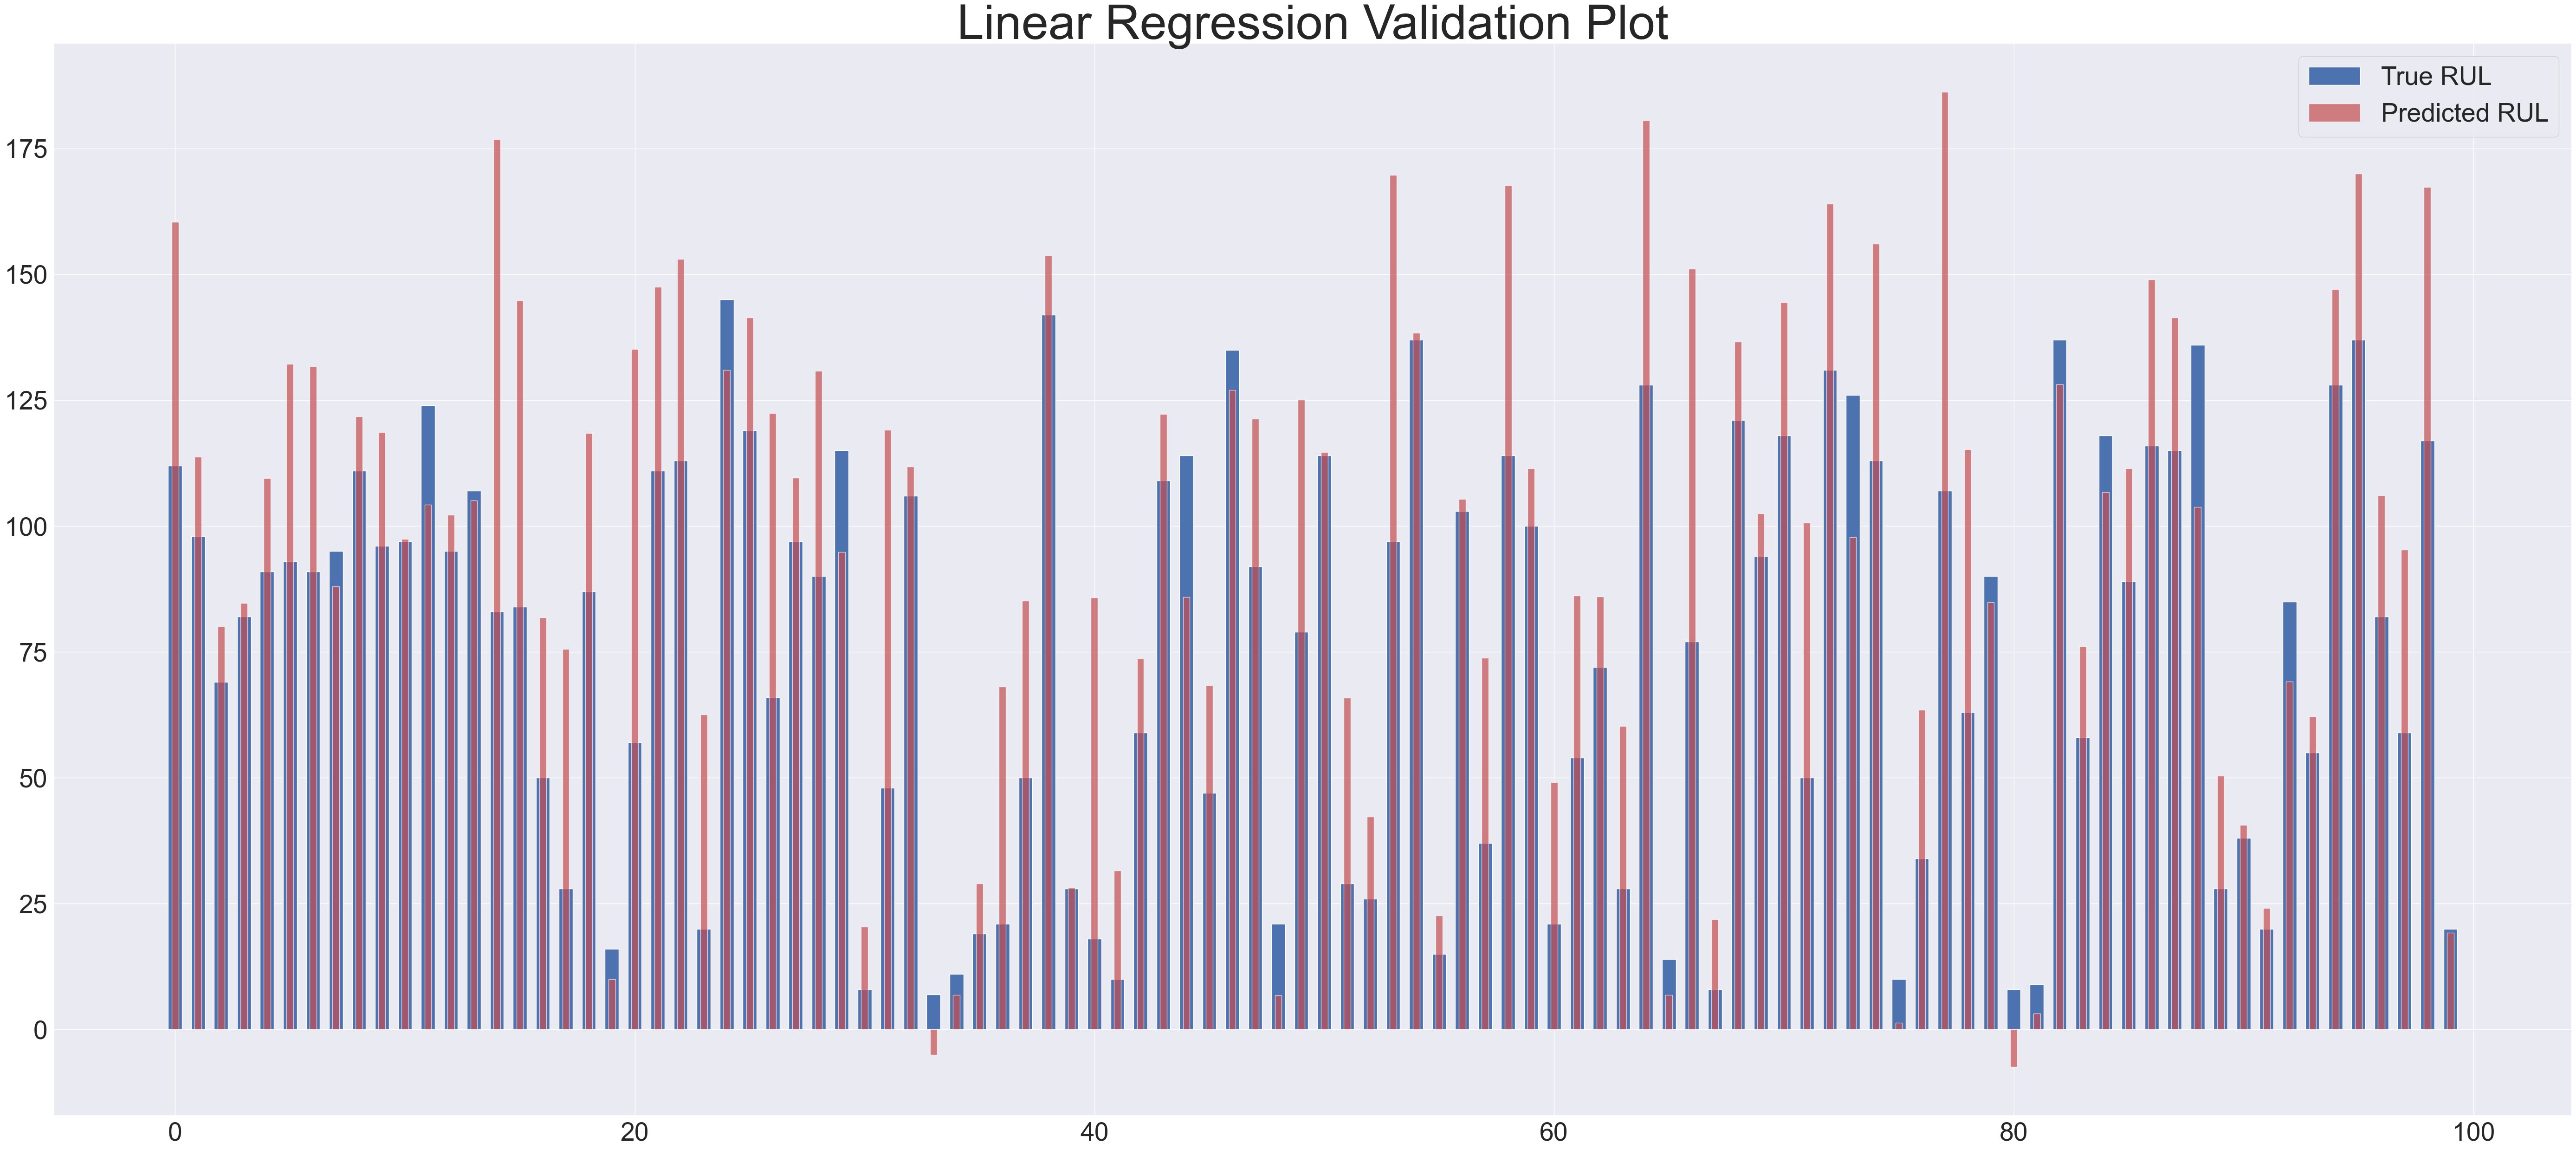

In [42]:
model_standardization(lr,'Linear Regression')

--- Random Forest Train Evaluation ---
MAE  : 12.4516
MSE  : 288.5869
RMSE : 16.9878
R²   : 0.9396
---------------------------
--- Random Forest Test Evaluation ---
MAE  : 32.9481
MSE  : 1952.9667
RMSE : 44.1924
R²   : 0.5769
---------------------------
--- Random Forest Valid Evaluation ---
MAE  : 25.3826
MSE  : 1216.2136
RMSE : 34.8743
R²   : 0.2957
---------------------------


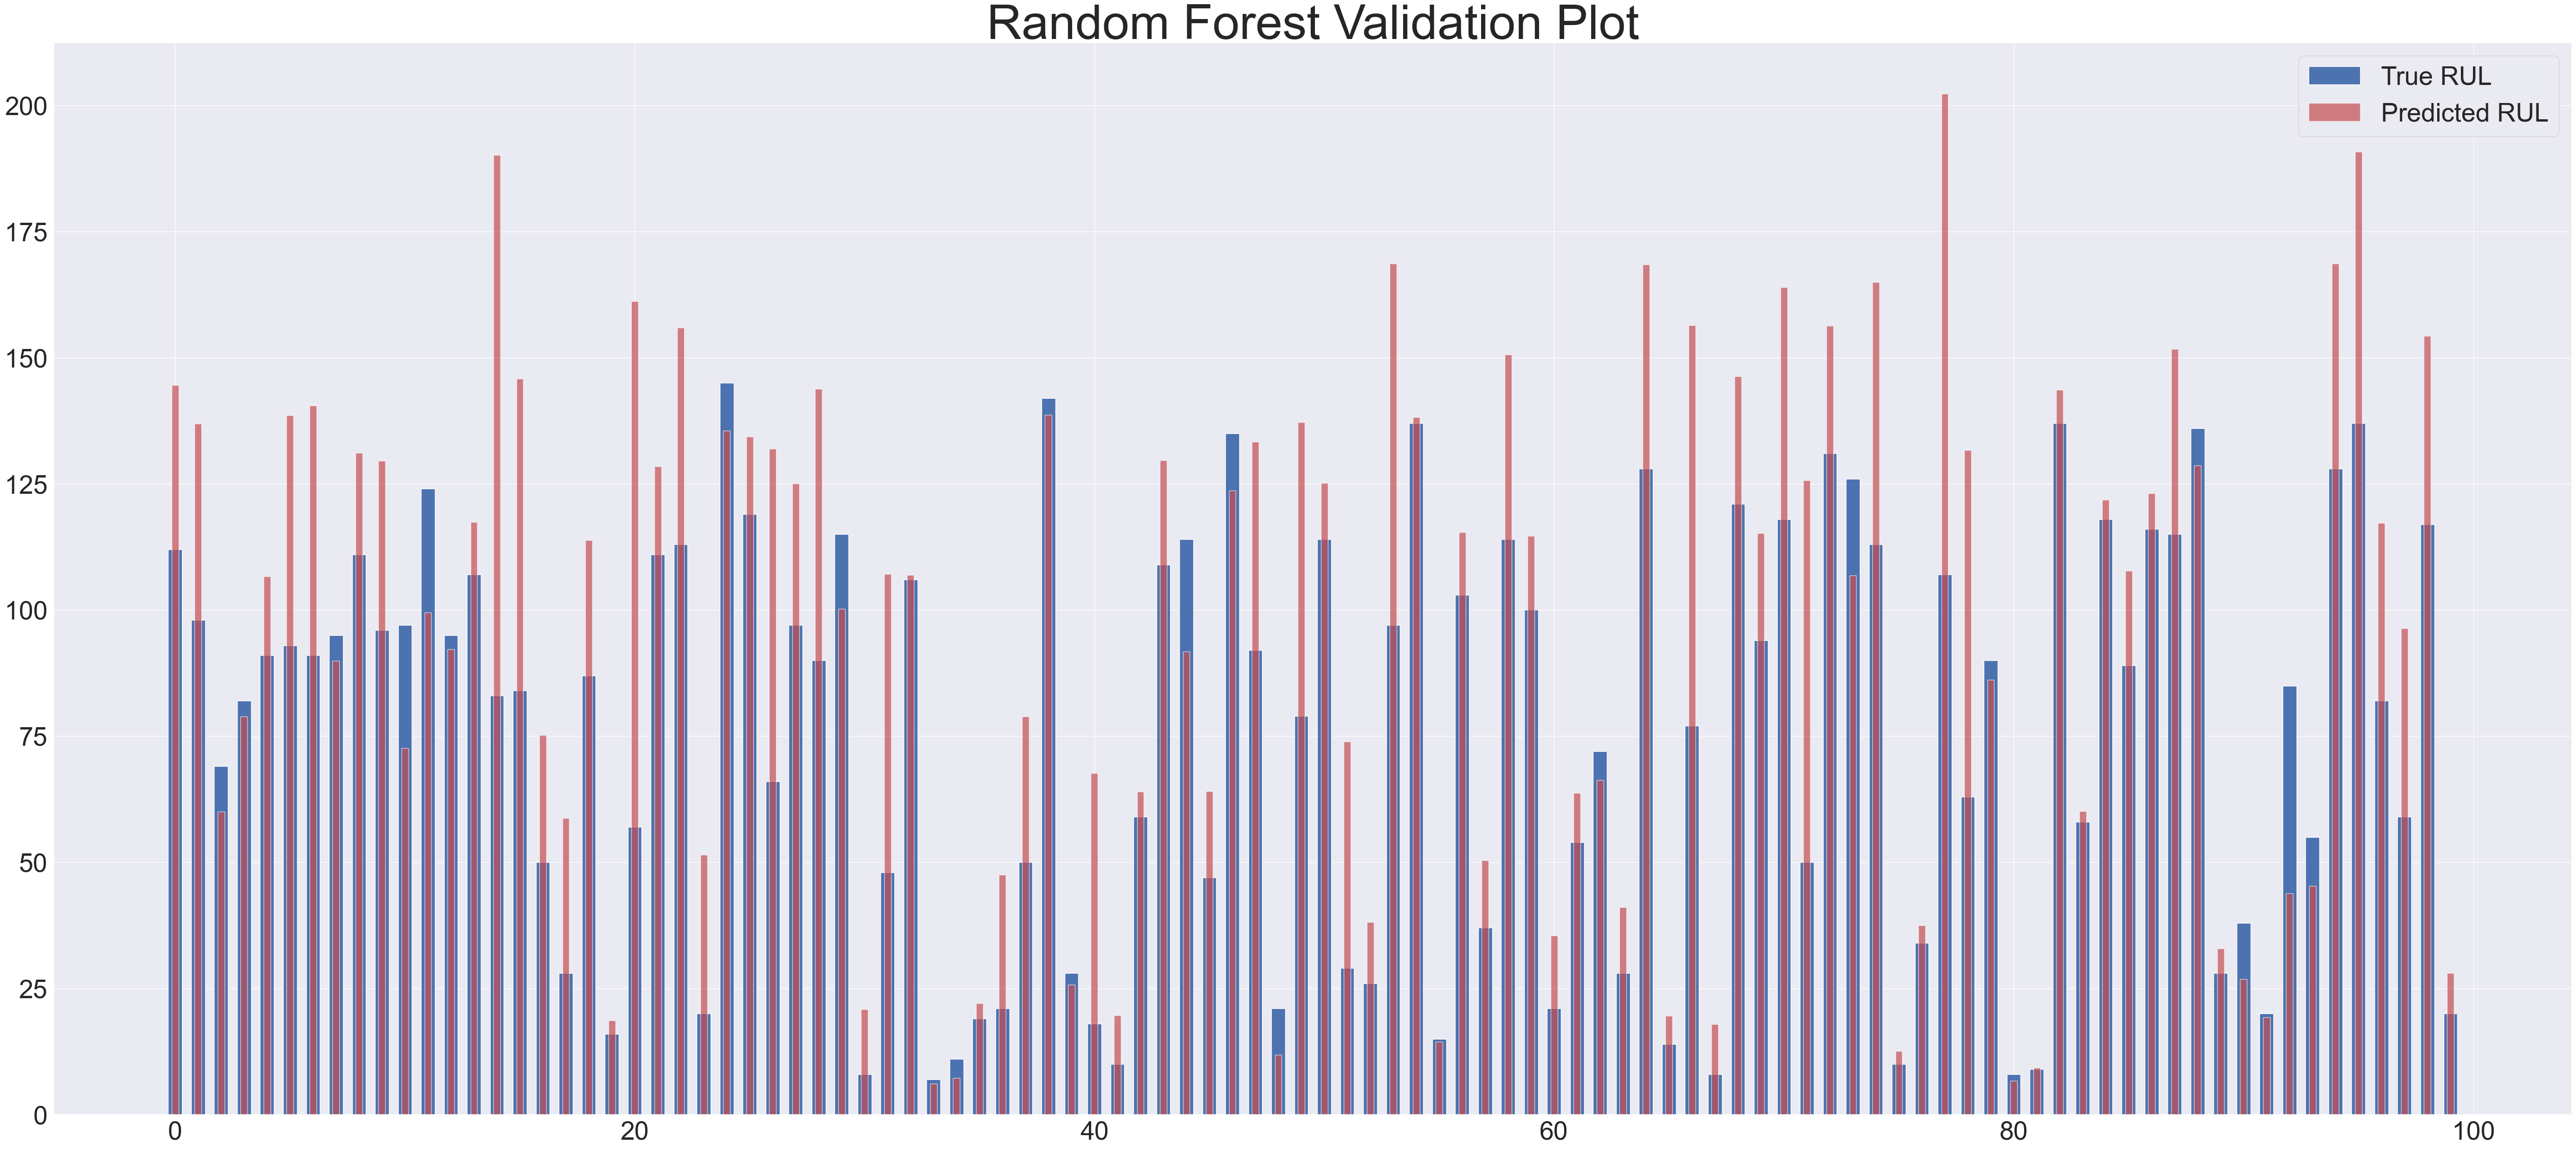

In [43]:
model_standardization(rf,'Random Forest')

--- SVR Train Evaluation ---
MAE  : 30.6192
MSE  : 1979.6554
RMSE : 44.4933
R²   : 0.5855
---------------------------
--- SVR Test Evaluation ---
MAE  : 31.5274
MSE  : 1942.3718
RMSE : 44.0723
R²   : 0.5792
---------------------------
--- SVR Valid Evaluation ---
MAE  : 22.8041
MSE  : 953.7867
RMSE : 30.8834
R²   : 0.4477
---------------------------


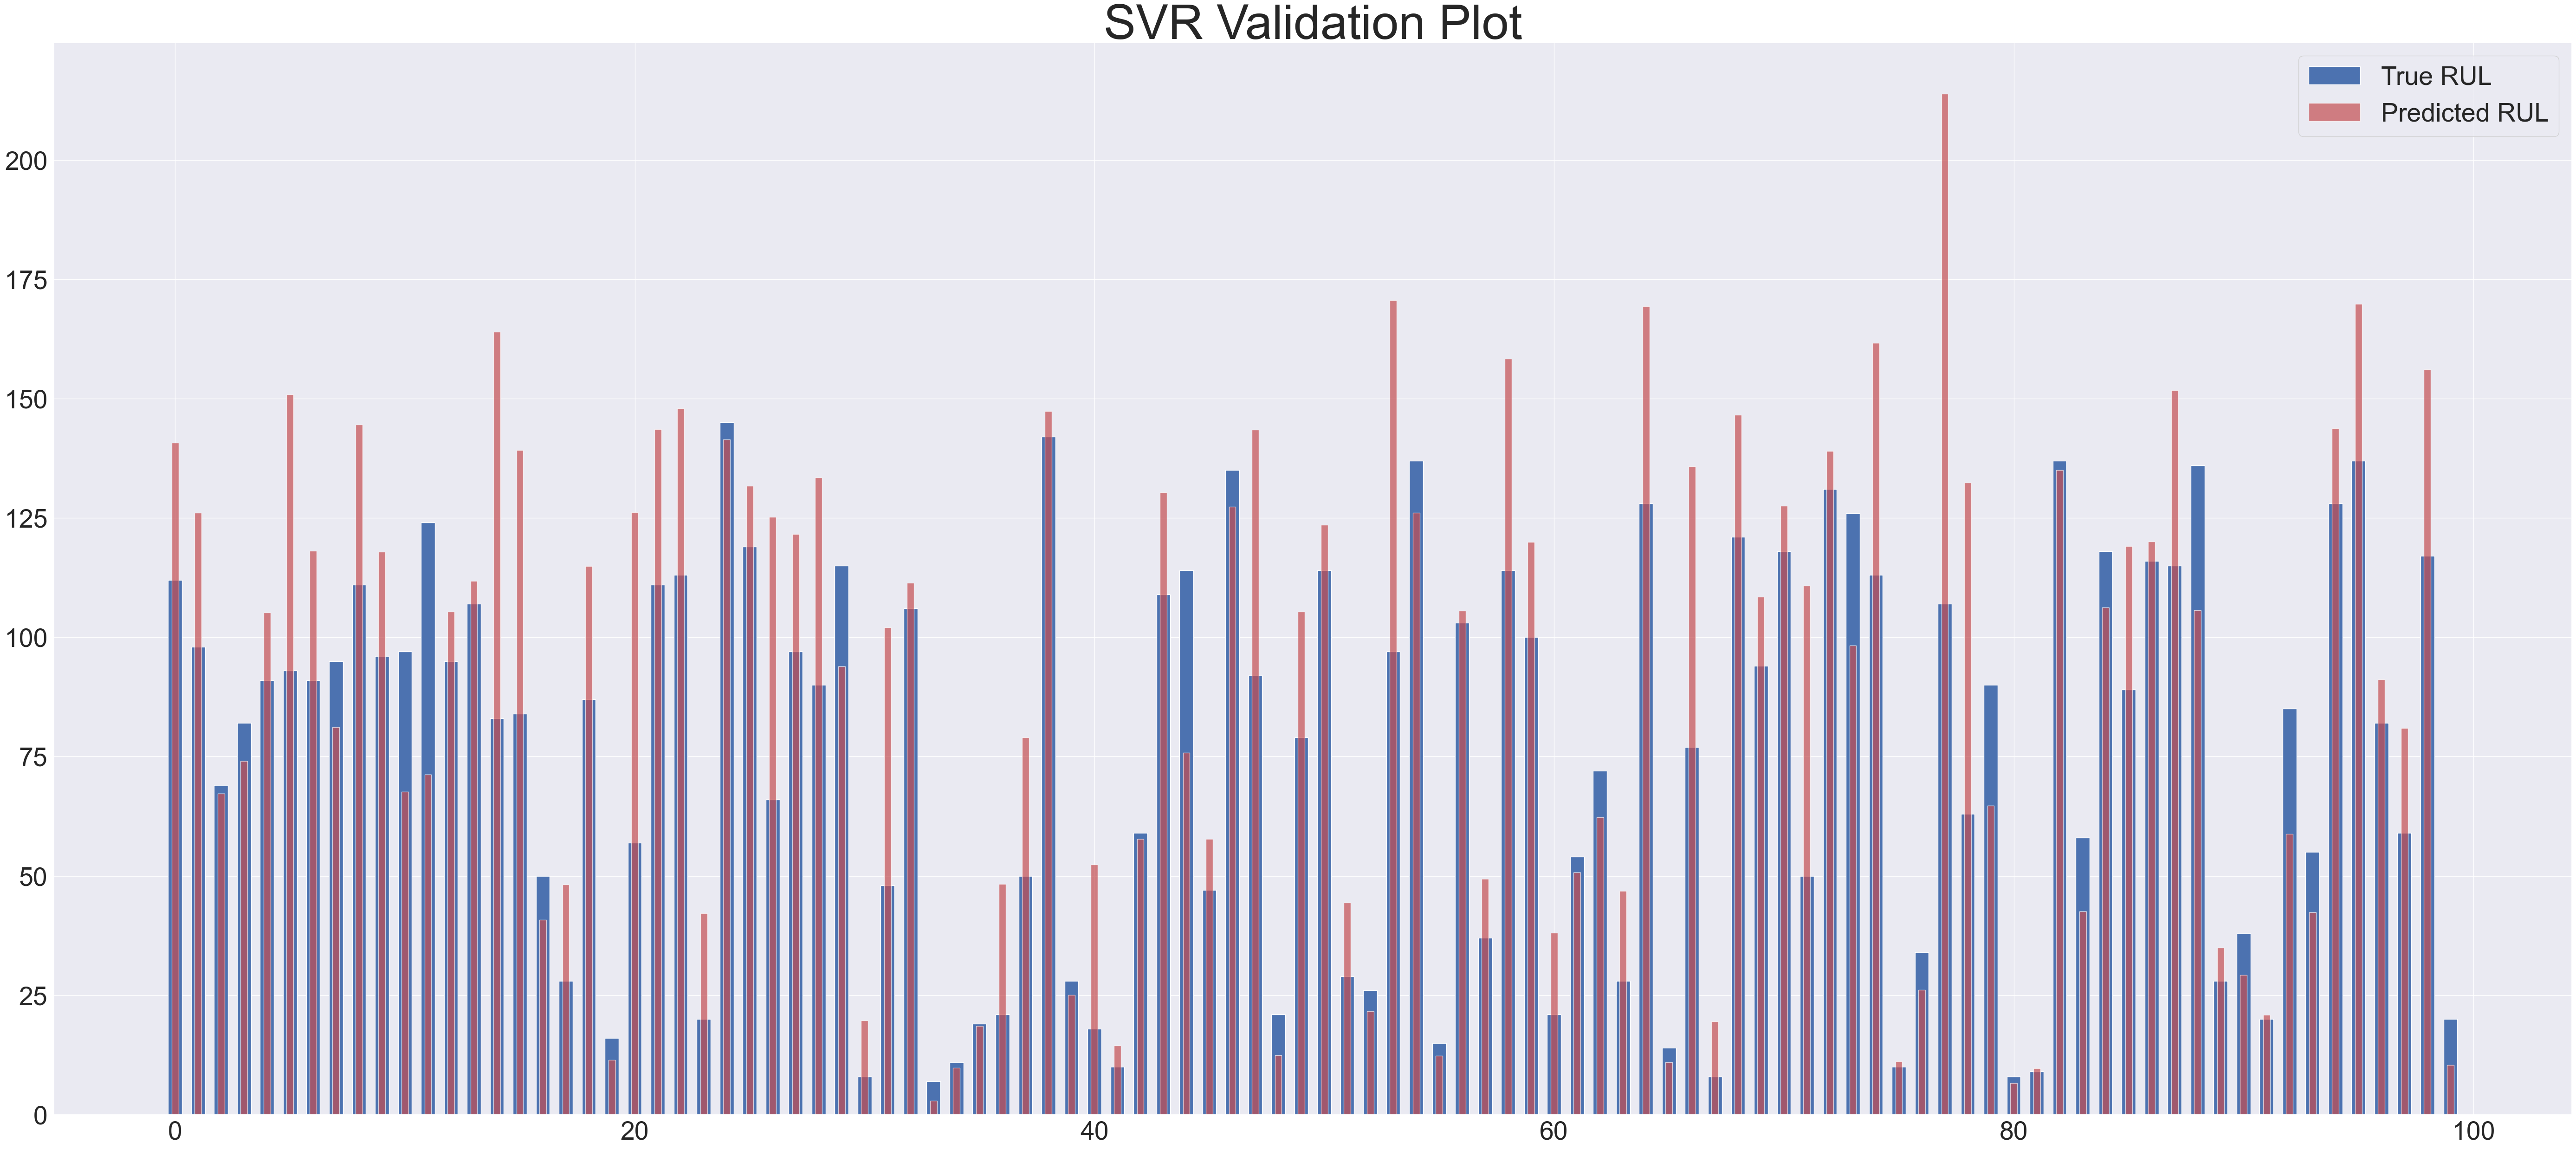

In [44]:
model_standardization(svr,'SVR')

--- XGBoost Train Evaluation ---
MAE  : 28.8464
MSE  : 1566.2283
RMSE : 39.5756
R²   : 0.6721
---------------------------
--- XGBoost Test Evaluation ---
MAE  : 32.4380
MSE  : 1923.0965
RMSE : 43.8531
R²   : 0.5834
---------------------------
--- XGBoost Valid Evaluation ---
MAE  : 24.5035
MSE  : 1114.5713
RMSE : 33.3852
R²   : 0.3546
---------------------------


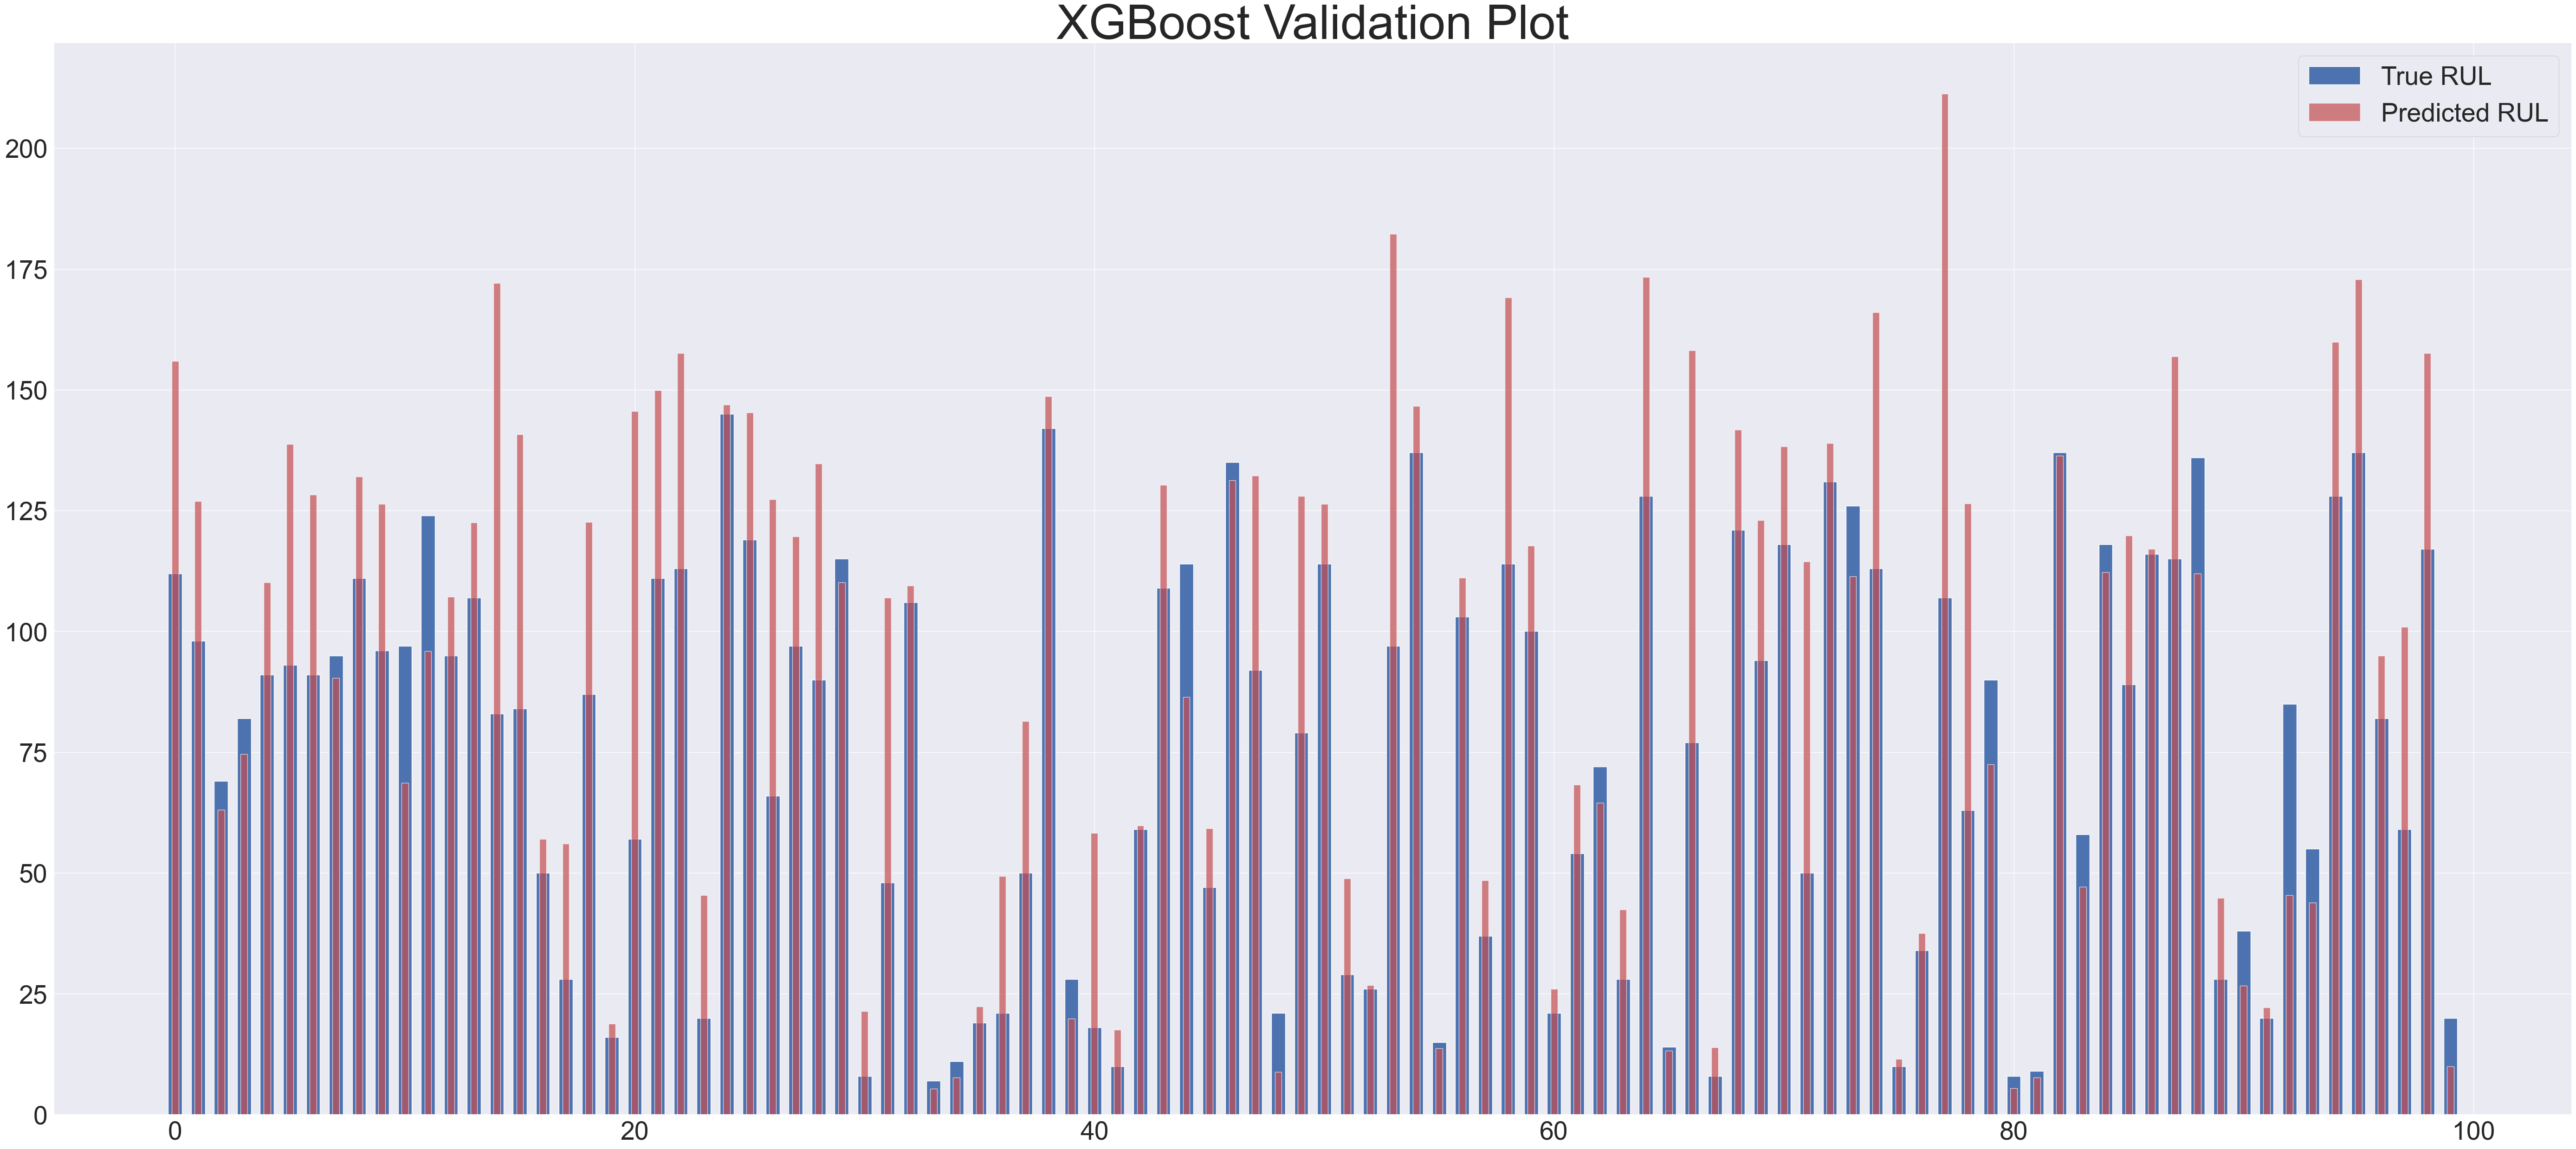

In [45]:
model_standardization(xg,'XGBoost')

In [46]:
eval_df

MAE        MSE     RMSE      R²
Linear Regression Train         34.8973  2107.1581  45.9038  0.5588
Linear Regression Test          34.1018  1975.3518  44.4449  0.5721
Linear Regression Valid         26.1888  1112.4743  33.3538  0.3558
Random Forest Train             12.4481   288.1353  16.9745  0.9397
Random Forest Test              32.8880  1946.5350  44.1196  0.5783
Random Forest Valid             25.5358  1223.4819  34.9783  0.2915
SVR Train                       45.5987  3358.1274  57.9494  0.2969
SVR Test                        45.0019  3216.7219  56.7162  0.3031
SVR Valid                       27.7691  1093.1235  33.0624  0.3670
XGBoost Train                   28.8464  1566.2283  39.5756  0.6721
XGBoost Test                    32.4365  1923.0140  43.8522  0.5834
XGBoost Valid                   24.5035  1114.5713  33.3852  0.3546
Linear Regression Train Scaled  34.8973  2107.1581  45.9038  0.5588
Linear Regression Test Scaled   34.1018  1975.3518  44.4449  0.5721
Linear Regression Valid Scaled  26.1888  1112.4743  33.3538  0.3558
Random Forest Train Scaled      12.4516   288.5869  16.9878  0.9396
Random Forest Test Scaled       32.9481  1952.9667  44.1924  0.5769
Random Forest Valid Scaled      25.3826  1216.2136  34.8743  0.2957
SVR Train Scaled                30.6192  1979.6554  44.4933  0.5855
SVR Test Scaled                 31.5274  1942.3718  44.0723  0.5792
SVR Valid Scaled                22.8041   953.7867  30.8834  0.4477
XGBoost Train Scaled            28.8464  1566.2283  39.5756  0.6721
XGBoost Test Scaled             32.4380  1923.0965  43.8531  0.5834
XGBoost Valid Scaled            24.5035  1114.5713  33.3852  0.3546

SVR with scaling gives the best results

### LSTM

Train shape: (16474, 30, 12) (16474,)
Val shape: (70, 30, 12) (70, 1)
Test shape: (4097, 30, 12) (4097,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           72192     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 121665 (475.25 KB)
Trainable params: 121665 (475.25 KB)
Non-trainable

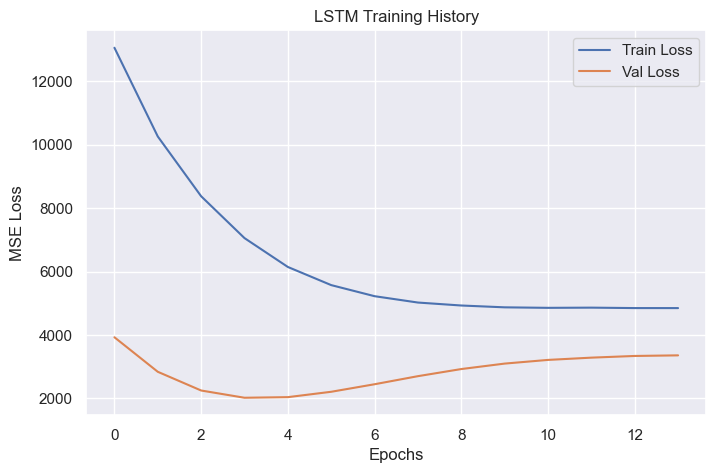

Test MSE: 6370.1753, Test MAE: 62.7657
129/129 [==============================] - 1s 6ms/step
LSTM RMSE: 79.8134
LSTM MAE: 63.0732
LSTM R²: -0.3792


In [48]:
def create_sequences(X, y, sequence_length=30):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i+sequence_length)])
        ys.append(y[i+sequence_length])
    return np.array(Xs), np.array(ys)

sequence_length = 30  # you can tune this

X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, sequence_length)
X_val_seq, y_val_seq     = create_sequences(valid.values, rul_df.values, sequence_length)
X_test_seq, y_test_seq   = create_sequences(X_test.values, y_test.values, sequence_length)

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Val shape:", X_val_seq.shape, y_val_seq.shape)
print("Test shape:", X_test_seq.shape, y_test_seq.shape)

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("LSTM Training History")
plt.show()

# Evaluate
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predictions
y_pred_lstm = model.predict(X_test_seq)

# Metrics
rmse = mean_squared_error(y_test_seq, y_pred_lstm, squared=False)
mae = mean_absolute_error(y_test_seq, y_pred_lstm)
r2 = r2_score(y_test_seq, y_pred_lstm)

print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM MAE: {mae:.4f}")
print(f"LSTM R²: {r2:.4f}")
